# Imports

In [ ]:
import re
import os
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
from tqdm.notebook import tqdm 
from wordcloud import WordCloud
from collections import Counter, defaultdict
from itertools import cycle

from transformers import (
    BertTokenizer,
    BertModel,
    BertConfig,
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification)
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    hamming_loss,
    accuracy_score,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score
)

from typing import List, Tuple, Dict, Any, Optional, Union

ImportError: cannot import name 'AdamW' from 'transformers' (c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\hatespeech-y9EfW-8H-py3.12\Lib\site-packages\transformers\__init__.py)

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data

In [88]:
DATA_FILE = "Data/train.csv"
DATA_TEST_FILE = "Data/test.csv"
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## Datasets

In [89]:
class ToxicityDataset(Dataset):
    def __init__(self,
                 data_source: Union[str, pd.DataFrame],
                 text_col: str = 'comment_text',
                 label_cols: List[str] = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                 id_col: Optional[str] = 'id'):
        
        if isinstance(data_source, str):
            self.data = pd.read_csv(data_source)
        elif isinstance(data_source, pd.DataFrame):
            self.data = data_source.copy()
        else:
            raise ValueError("data_source must be a file path or a pandas DataFrame.")
        
        initial_len = len(self.data)
        self.data = self.data.dropna(subset=[text_col])
        if len(self.data) < initial_len:
            print(f"Removed {initial_len - len(self.data)} rows with empty values in '{text_col}'.")

        # filter zero length
        initial_len_before_token_filter = len(self.data)

        clean_vectorized = np.vectorize(self._clean_text)
        tokenize_vectorized = np.vectorize(self._tokenize, otypes=[object])

        cleaned_texts = clean_vectorized(self.data[text_col].astype(str))
        tokens_list = tokenize_vectorized(cleaned_texts)

        token_lengths = np.array([len(tokens) for tokens in tokens_list])

        mask_valid_length = token_lengths > 0

        self.data = self.data[mask_valid_length].reset_index(drop=True)

        zero_token_dropped = initial_len_before_token_filter - len(self.data)
        if zero_token_dropped > 0:
             print(f"Removed {zero_token_dropped} rows of zero length.")

        self.text_col = text_col
        self.label_cols = label_cols
        self.id_col = id_col

        self.texts = self.data[self.text_col].astype(str).tolist()
        self.labels = torch.tensor(self.data[self.label_cols].values, dtype=torch.float32)

        self.ids = None
        if self.id_col and self.id_col in self.data.columns:
            self.ids = self.data[self.id_col].tolist()

    def _clean_text(self, text : str) -> str:
        text = text.lower()
        text = re.sub(r'<[^>]+>', '', text) # remove HTML tags
        text = re.sub(r'http\S+', '', text) # remove URLs
        text = re.sub(r'[^\w\s]', '', text) # remove punctuation and special characters
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def _tokenize(self, text: str) -> List[str]:
        tokens = text.split()
        tokens = [token for token in tokens if token]
        return tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        raw_text = self.texts[idx]
        labels = self.labels[idx]
        item_id = self.ids[idx] if self.ids else None

        cleaned_text = self._clean_text(raw_text)
        tokens = self._tokenize(cleaned_text)
        
        return {
            'id': item_id,
            "raw_text": raw_text,
            'cleaned_text': cleaned_text,
            'tokens': tokens,
            'labels': labels,
        }


In [90]:
class BertToxicityDataset(ToxicityDataset):
    def __init__(self,
                 data_source: Union[str, pd.DataFrame],
                 tokenizer_name: str = 'bert-base-uncased',
                 max_seq_len: int = 128,
                 text_col: str = 'comment_text',
                 label_cols: List[str] = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
                 id_col: Optional[str] = 'id'):

        super().__init__(data_source, text_col, label_cols, id_col)

        print(f"Loading BERT tokenizer: {tokenizer_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_seq_len = max_seq_len
        print("Tokenizer loaded.")

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        raw_text = self.texts[idx]
        labels = self.labels[idx]
        item_id = self.ids[idx] if self.ids else None

        # tokenizer returns 'input_ids', 'token_type_ids', 'attention_mask'
        encoding = self.tokenizer.encode_plus(
            raw_text,
            add_special_tokens=True, # [CLS] & [SEP]
            max_length=self.max_seq_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'id': item_id,
            'raw_text': raw_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

## Loading

In [91]:
RANDOM_STATE = 42
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [92]:
full_df = pd.read_csv(DATA_FILE)

train_val_df, test_df = train_test_split(
    full_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

relative_valid_size = VAL_SIZE / (1 - TEST_SIZE)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=relative_valid_size,
    random_state=RANDOM_STATE
)

# test_df = pd.read_csv(DATA_TEST_FILE)

# Preprocessing

## TF-IDF

In [93]:
def fit_tfidf_vectorizer(texts: List[str], max_features: Optional[int] = 10000, save_path: Optional[str] = 'tfidf_vectorizer.joblib') -> TfidfVectorizer:
    print(f"Fitting TF-IDF on {len(texts)} texts...")
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    vectorizer.fit(texts)
    print(f"Vocab size: {len(vectorizer.vocabulary_)}")

    if save_path:
        joblib.dump(vectorizer, save_path)
        print(f"Saved at: {save_path}")

    return vectorizer

def vectorize_tfidf(texts: List[str], vectorizer: TfidfVectorizer) -> np.ndarray:
    print(f"Vectorizing {len(texts)} with TF-IDF...")
    tfidf_matrix = vectorizer.transform(texts)
    return tfidf_matrix.toarray()

In [94]:
# texts_tfidf = [sample['cleaned_text'] for sample in train_df]
# fitted_vectorizer = fit_tfidf_vectorizer(texts_tfidf, max_features=100, save_path=None)
# vectors = vectorize_tfidf(texts_tfidf, fitted_vectorizer)
# print("TF-IDF vectors:")
# print(vectors)
# print("Vectors size:", vectors.shape)

## GloVe

In [95]:
class GloveHelper:
    def __init__(self, glove_path: str):
        print(f"Loading vectors from: {glove_path}...")
        self.word_to_vec = {}
        self.embedding_dim = 0
        try:
            with open(glove_path, 'r', encoding='utf-8') as f:
                for line in tqdm(f, desc="Loading GloVe"):
                    values = line.split()
                    word = values[0]
                    try:
                        vector = np.asarray(values[1:], dtype='float32')
                        if self.embedding_dim == 0:
                           self.embedding_dim = len(vector)
                        elif len(vector) != self.embedding_dim:
                             print(f"Warning: Skipping word '{word}' due to inconsistent embedding dimension.")
                             continue
                        self.word_to_vec[word] = vector
                    except ValueError:
                         print(f"Warning: Skipping word '{word}' due to parsing error.")


            # For unknown words (OOV - Out Of Vocabulary)
            self.unknown_vector = np.zeros(self.embedding_dim, dtype='float32')
            print(f"GloVe vectors loaded. Vocab size: {len(self.word_to_vec)}, Dimension: {self.embedding_dim}")

        except Exception as e:
            print(f"Error while loading: {e}")
            raise

    def get_embedding_dim(self) -> int:
        return self.embedding_dim

    def get_vector(self, word: str) -> np.ndarray:
        return self.word_to_vec.get(word.lower(), self.unknown_vector)

    def vectorize_average(self, tokens: List[str]) -> np.ndarray:
        vectors = [self.get_vector(token) for token in tokens]
        if not vectors:
            return self.unknown_vector
        return np.mean(vectors, axis=0)

    def vectorize_sequence(self, tokens: List[str], max_len: int, pad_to_max: bool = True) -> Tuple[np.ndarray, int]:
        actual_len = min(len(tokens), max_len)
        vectors = [self.get_vector(token) for token in tokens[:actual_len]]

        sequence_matrix = np.array(vectors, dtype='float32')

        if pad_to_max and actual_len < max_len:
            padding_len = max_len - actual_len
            padding = np.zeros((padding_len, self.embedding_dim), dtype='float32')
            if sequence_matrix.size == 0:
                 sequence_matrix = padding
            else:
                 sequence_matrix = np.vstack((sequence_matrix, padding))

        elif not pad_to_max and sequence_matrix.size == 0:
             sequence_matrix = np.zeros((0, self.embedding_dim), dtype='float32')

        return sequence_matrix, min(len(tokens), max_len)


In [96]:
# trained on Wikipedia 2014 + Gigaword 5
GLOVE_FILE = 'Data/Glove6B/glove.6B.100d.txt'

glove_helper = GloveHelper(GLOVE_FILE)
tokens_example = ["this", "is", "an", "example", "sentence", "with", "unknownword"]

# For logistic regression
avg_vector = glove_helper.vectorize_average(tokens_example)
print("\nGloVe Average:")
print(avg_vector.shape)
print(avg_vector)

# For LSTM (with padding)
MAX_SEQUENCE_LENGTH = 10
sequence_vectors, actual_length = glove_helper.vectorize_sequence(tokens_example, max_len=MAX_SEQUENCE_LENGTH, pad_to_max=True)
print(f"\nGloVe sequence (padded to {MAX_SEQUENCE_LENGTH}):")
print(sequence_vectors.shape)
print(f"Real length before padding/shrink: {actual_length}")
print(sequence_vectors)

Loading vectors from: Data/Glove6B/glove.6B.100d.txt...


Loading GloVe: 0it [00:00, ?it/s]

GloVe vectors loaded. Vocab size: 400000, Dimension: 100

GloVe Average:
(100,)
[-0.21109572  0.2604857   0.40744072 -0.14264715  0.23383571  0.3075957
 -0.05085072  0.21934286 -0.24029315  0.21335001 -0.18643244 -0.02580343
  0.13575071  0.02670573  0.23204972 -0.10078257  0.15724228 -0.19450013
 -0.2505886   0.22560088  0.1767683  -0.2757943   0.10008157  0.19322
  0.42253473 -0.00367286 -0.00754915 -0.45341715 -0.18070629 -0.02115686
 -0.16832002  0.56561655 -0.02168128 -0.10612043  0.03138314  0.2511513
  0.20386744  0.16239142  0.07682186 -0.14169571 -0.21204142 -0.05904228
  0.30415586 -0.23490158  0.13593714  0.01458057  0.51891    -0.43129
 -0.20718858 -0.46581432  0.22369972 -0.3397944   0.43440026  1.0991358
 -0.47381857 -2.2747328  -0.05157657 -0.35662702  1.4138143   0.4789657
 -0.10194     0.41199997 -0.14049429 -0.10549115  0.761055   -0.26080927
  0.4949443   0.2288443   0.05061213  0.00537427 -0.12242985 -0.19823216
  0.00375715 -0.17687571  0.35772854  0.09062086 -0.14

## BERT word embeddings

In [97]:
print("Creating BERT dataset...")
bert_dataset = BertToxicityDataset(train_df, max_seq_len=64)

bert_sample = bert_dataset[1]
print(f"ID: {bert_sample['id']}")
print(f"Raw Text: {bert_sample['raw_text']}")
print(f"Input IDs: {bert_sample['input_ids'].shape}\n{bert_sample['input_ids']}")
print(f"Attention Mask: {bert_sample['attention_mask'].shape}\n{bert_sample['attention_mask']}")
print(f"Labels: {bert_sample['labels']}")

Creating BERT dataset...
Removed 8 rows of zero length.
Loading BERT tokenizer: bert-base-uncased...
Tokenizer loaded.
ID: 7caf6adbf670d195
Raw Text: "

We could just state that Gandhi was ""Indian"", and place a note for the Queen stating that as a monarch or multiple states she has no one nationality. I think that's clearer than using political flags, some of which seem a bit innapropriate. 84.92.117.93  "
Input IDs: torch.Size([64])
tensor([  101,  1000,  2057,  2071,  2074,  2110,  2008, 12338,  2001,  1000,
         1000,  2796,  1000,  1000,  1010,  1998,  2173,  1037,  3602,  2005,
         1996,  3035,  5517,  2008,  2004,  1037, 11590,  2030,  3674,  2163,
         2016,  2038,  2053,  2028, 10662,  1012,  1045,  2228,  2008,  1005,
         1055, 24509,  2084,  2478,  2576,  9245,  1010,  2070,  1997,  2029,
         4025,  1037,  2978,  7601,  9331, 18981,  4360,  2618,  1012,  6391,
         1012,  6227,  1012,   102])
Attention Mask: torch.Size([64])
tensor([1, 1, 1, 1, 1,

## Collate

In [98]:
def collate_fn_tfidf(batch: List[Dict[str, Any]], vectorizer: TfidfVectorizer) -> Dict[str, Any]:
    texts = [item['cleaned_text'] for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    ids = [item['id'] for item in batch]

    tfidf_vectors = torch.tensor(vectorizer.transform(texts).toarray(), dtype=torch.float32)

    return {
        'id': ids,
        'features': tfidf_vectors,
        'labels': labels
    }

# for Logistic Regression
def collate_fn_glove_avg(batch: List[Dict[str, Any]], glove_helper: GloveHelper) -> Dict[str, Any]:
    vectors = [glove_helper.vectorize_average(item['tokens']) for item in batch]
    labels = torch.stack([item['labels'] for item in batch])
    ids = [item['id'] for item in batch]

    avg_vectors_tensor = torch.tensor(np.array(vectors), dtype=torch.float32)

    return {
        'id': ids,
        'features': avg_vectors_tensor,
        'labels': labels
    }

# for LSTM
def collate_fn_glove_seq(batch: List[Dict[str, Any]], glove_helper: GloveHelper, max_len: int) -> Dict[str, Any]:
    sequences = []
    actual_lengths = []
    labels = torch.stack([item['labels'] for item in batch])
    ids = [item['id'] for item in batch]

    for item in batch:
        seq_matrix, actual_len = glove_helper.vectorize_sequence(
            item['tokens'], max_len=max_len, pad_to_max=True
        )
        sequences.append(torch.tensor(seq_matrix, dtype=torch.float32))
        actual_lengths.append(actual_len)

    padded_sequences = torch.stack(sequences)
    lengths_tensor = torch.tensor(actual_lengths, dtype=torch.int64)

    return {
        'id': ids,
        'sequences': padded_sequences,
        'lengths': lengths_tensor,
        'labels': labels
    }

# Visulaize

In [99]:
# 1. TF-IDF
print("\n--- TF-IDF ---")
train_texts_for_tfidf = [text.lower() for text in train_df['comment_text'].astype(str).tolist()]
train_texts_for_tfidf = [re.sub(r'[^a-z0-9\s]', '', text) for text in train_texts_for_tfidf]
train_texts_for_tfidf = [re.sub(r'\s+', ' ', text).strip() for text in train_texts_for_tfidf]

MAX_FEATURES_TFIDF = 20_000
tfidf_vectorizer = fit_tfidf_vectorizer(train_texts_for_tfidf, max_features=MAX_FEATURES_TFIDF, save_path='tfidf_vectorizer.joblib')

# tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
# print("Loaded TF-IDF vectorizer from file.")


--- TF-IDF ---
Fitting TF-IDF on 111699 texts...
Vocab size: 20000
Saved at: tfidf_vectorizer.joblib


In [100]:
# 2. GloVe
print("\n--- GloVe ---")
GLOVE_FILE_PATH = 'Data/Glove6B/glove.6B.100d.txt'
glove_helper = GloveHelper(GLOVE_FILE_PATH)


--- GloVe ---
Loading vectors from: Data/Glove6B/glove.6B.100d.txt...


Loading GloVe: 0it [00:00, ?it/s]

GloVe vectors loaded. Vocab size: 400000, Dimension: 100


In [101]:
# 3. BERT Tokenizer is loaded inside BertToxicityDataset

train_dataset_base = ToxicityDataset(data_source=train_df)
val_dataset_base = ToxicityDataset(data_source=val_df)
test_dataset_base = ToxicityDataset(data_source=test_df)

BERT_MODEL_NAME = 'bert-base-uncased'
BERT_MAX_LEN = 128
train_dataset_bert = BertToxicityDataset(data_source=train_df, tokenizer_name=BERT_MODEL_NAME, max_seq_len=BERT_MAX_LEN)
val_dataset_bert = BertToxicityDataset(data_source=val_df, tokenizer_name=BERT_MODEL_NAME, max_seq_len=BERT_MAX_LEN)
test_dataset_bert = BertToxicityDataset(data_source=test_df, tokenizer_name=BERT_MODEL_NAME, max_seq_len=BERT_MAX_LEN)


Removed 8 rows of zero length.
Removed 2 rows of zero length.
Removed 3 rows of zero length.
Removed 8 rows of zero length.
Loading BERT tokenizer: bert-base-uncased...
Tokenizer loaded.
Removed 2 rows of zero length.
Loading BERT tokenizer: bert-base-uncased...
Tokenizer loaded.
Removed 3 rows of zero length.
Loading BERT tokenizer: bert-base-uncased...
Tokenizer loaded.


In [102]:
import nltk
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

## 1. Labels distribution


--- (train_df 111699) ---


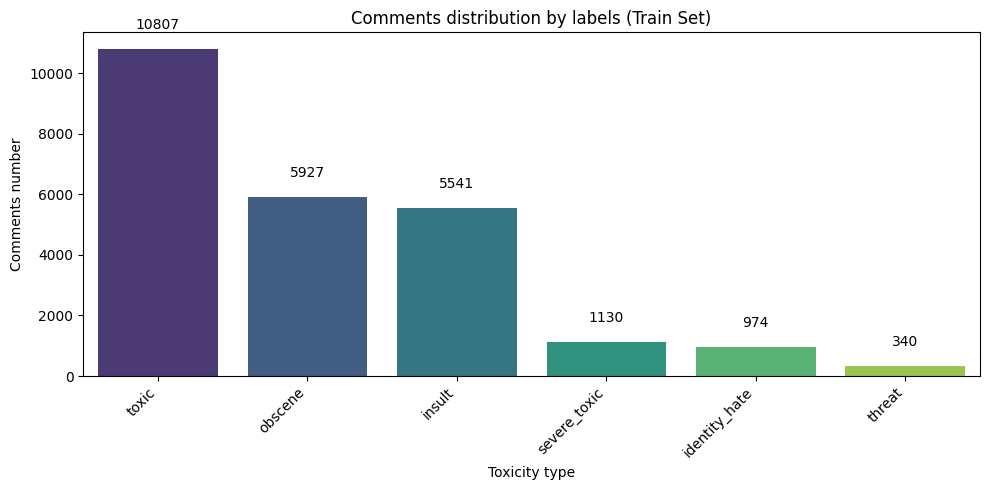

In [103]:
print(f"\n--- (train_df {len(train_df)}) ---")

def plot_label_distribution(df, label_cols):
    plt.figure(figsize=(10, 5))
    label_counts = df[label_cols].sum().sort_values(ascending=False)
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis", hue=label_counts.index, legend=False)
    plt.title('Comments distribution by labels (Train Set)')
    plt.ylabel('Comments number')
    plt.xlabel('Toxicity type')
    plt.xticks(rotation=45, ha='right')
    for i, count in enumerate(label_counts.values):
        plt.text(i, count + len(df)*0.005, str(count), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

plot_label_distribution(train_df, label_cols)

## 2. Labels per comment

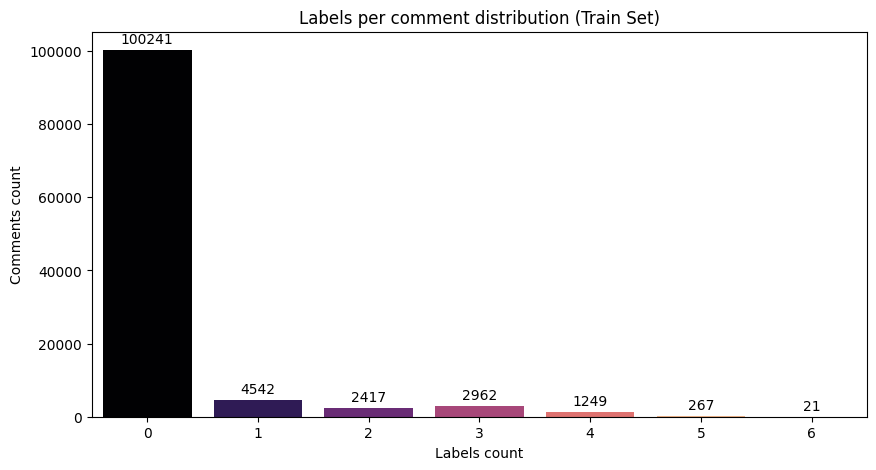

   % of comments with no labels: 89.74%


In [104]:
# --- 2. Labels per comment ---
def plot_num_labels_per_comment(df, label_cols):
    row_sums = df[label_cols].sum(axis=1)
    num_labels_counts = row_sums.value_counts().sort_index()

    plt.figure(figsize=(10, 5))
    sns.barplot(x=num_labels_counts.index, y=num_labels_counts.values, palette="magma", hue=num_labels_counts.index, legend=False)
    plt.title('Labels per comment distribution (Train Set)')
    plt.xlabel('Labels count')
    plt.ylabel('Comments count')
    for i, count in enumerate(num_labels_counts.values):
        plt.text(i, count + num_labels_counts.values.max()*0.01, str(count), ha='center', va='bottom')
    plt.show()

    clean_comments_percentage = (row_sums == 0).mean() * 100
    print(f"   % of comments with no labels: {clean_comments_percentage:.2f}%")

plot_num_labels_per_comment(train_df, label_cols)


## 3. Correlations between labels

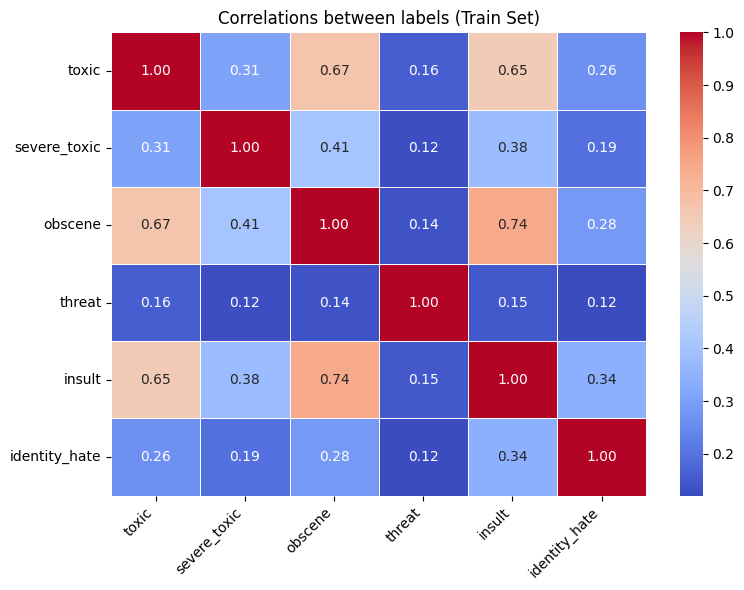

In [105]:
# --- 3. Correlations between labels ---
def plot_label_correlation(df, label_cols):
    correlation_matrix = df[label_cols].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title('Correlations between labels (Train Set)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_label_correlation(train_df, label_cols)

## 4. Comment length

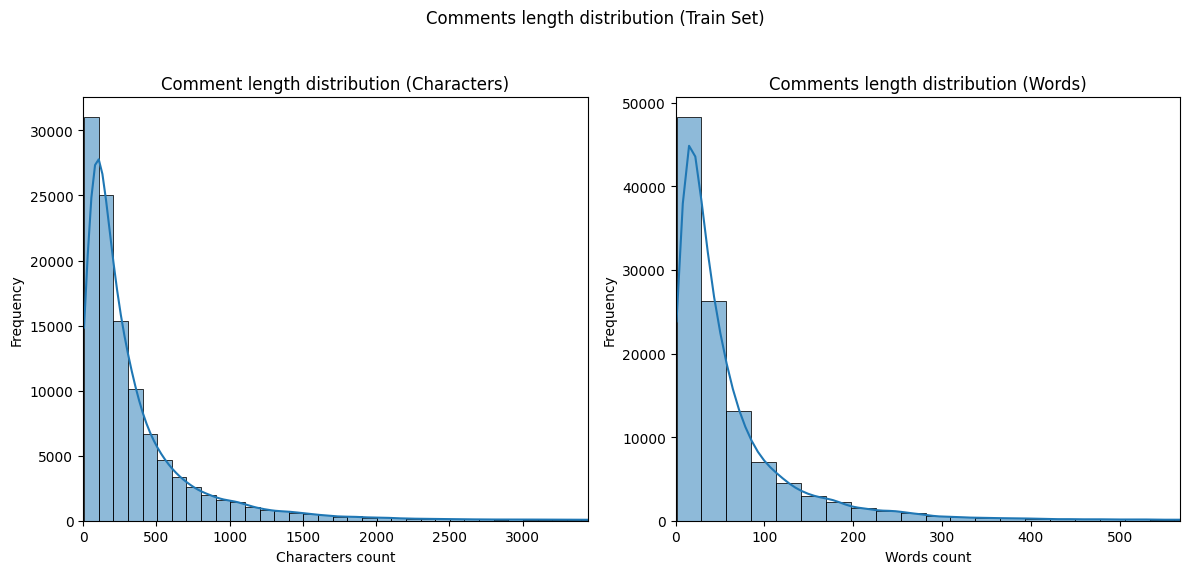

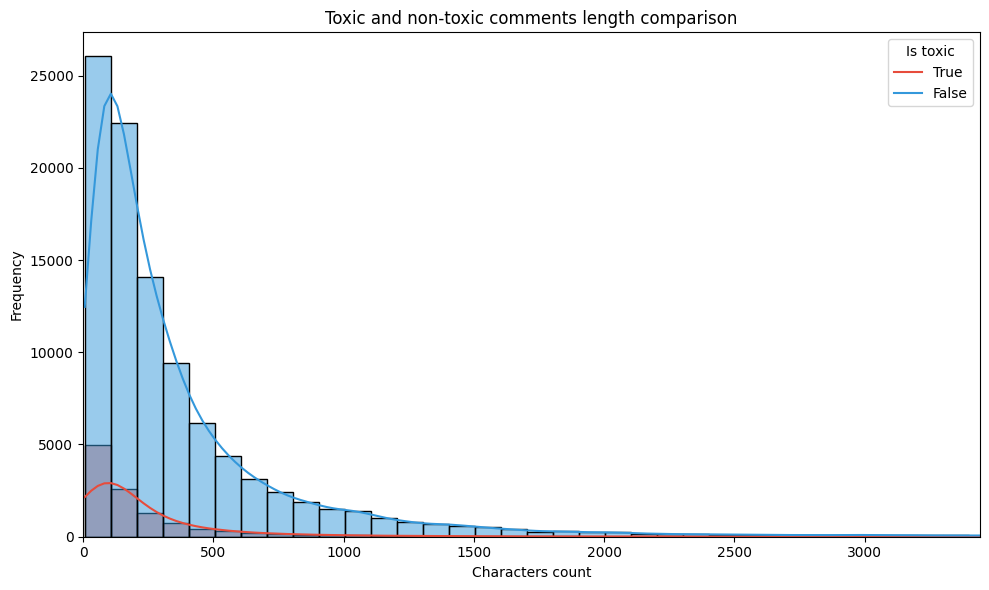

In [106]:
train_df['comment_length_char'] = train_df['comment_text'].astype(str).str.len()
train_df['comment_length_words'] = train_df['comment_text'].astype(str).apply(lambda x: len(x.split()))

train_df['is_toxic'] = train_df[label_cols].sum(axis=1) > 0

def plot_comment_length_distribution(df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['comment_length_char'], bins=50, kde=True)
    max_char_lim = np.percentile(df['comment_length_char'], 99)
    plt.xlim(0, max_char_lim)
    plt.title('Comment length distribution (Characters)')
    plt.xlabel('Characters count')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df['comment_length_words'], bins=50, kde=True)
    max_word_lim = np.percentile(df['comment_length_words'], 99)
    plt.xlim(0, max_word_lim)
    plt.title('Comments length distribution (Words)')
    plt.xlabel('Words count')
    plt.ylabel('Frequency')

    plt.suptitle('Comments length distribution (Train Set)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='comment_length_char', hue='is_toxic', bins=50, kde=True, palette=['#3498db', '#e74c3c'])
    plt.xlim(0, max_char_lim)
    plt.title('Toxic and non-toxic comments length comparison')
    plt.xlabel('Characters count')
    plt.ylabel('Frequency')
    plt.legend(title='Is toxic', labels=['True', 'False'])
    plt.tight_layout()
    plt.show()

plot_comment_length_distribution(train_df)

In [107]:
RANDOM_STATE = 42

## 5. Wordcloud

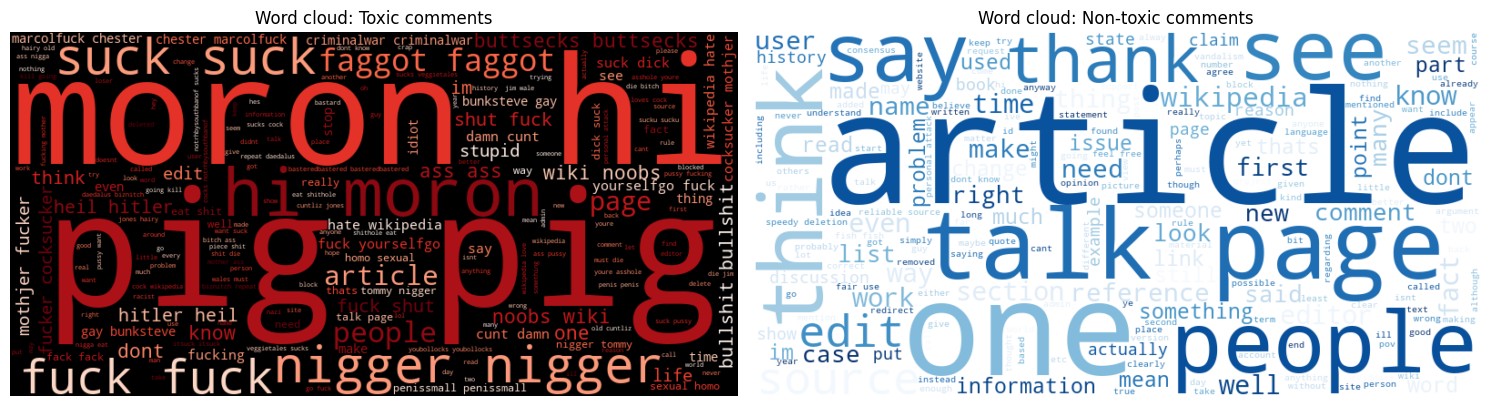

In [108]:
def preprocess_text_for_wordcloud(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOPWORDS and len(word) > 1]
    return " ".join(tokens)

def plot_word_clouds(df):
    toxic_texts = df[df['is_toxic'] == True]['comment_text'].apply(preprocess_text_for_wordcloud)
    non_toxic_texts = df[df['is_toxic'] == False]['comment_text'].apply(preprocess_text_for_wordcloud)

    toxic_text_combined = " ".join(toxic_texts)
    non_toxic_text_combined = " ".join(non_toxic_texts)

    wordcloud_toxic = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(toxic_text_combined)
    wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(non_toxic_text_combined)

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_toxic, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word cloud: Toxic comments')

    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word cloud: Non-toxic comments')

    plt.tight_layout()
    plt.show()

plot_word_clouds(train_df.sample(n=min(len(train_df), 50000), random_state=RANDOM_STATE))


## 6. Embeddings

In [109]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [110]:
print("\n--- (Sentence-Level GloVe Average) ---")

N_SAMPLES = 3000
PERPLEXITY = 30 # 5-50

if len(train_df) > N_SAMPLES:
    print(f"Selecting {N_SAMPLES} samples...")
    viz_df = train_df.sample(n=N_SAMPLES, random_state=RANDOM_STATE).copy()
else:
    print("Using all samples...")
    viz_df = train_df.copy()

if 'tokens' not in viz_df.columns:
    # cleaning like in ToxicCommentDataset
    def temp_clean_tokenize(text):
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return [token for token in text.split() if token]
    viz_df['tokens'] = viz_df['comment_text'].apply(temp_clean_tokenize)


embeddings = np.array([glove_helper.vectorize_average(tokens) for tokens in viz_df['tokens']])
print(f"Got {embeddings.shape[0]} embeddings of size {embeddings.shape[1]}")

if np.isnan(embeddings).any() or np.isinf(embeddings).any():
    embeddings = np.nan_to_num(embeddings)

# 1. PCA
print("Applying PCA (2D & 3D)...")
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
embeddings_pca_2d = pca_2d.fit_transform(embeddings)

pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
embeddings_pca_3d = pca_3d.fit_transform(embeddings)

viz_df['pca_x'] = embeddings_pca_2d[:, 0]
viz_df['pca_y'] = embeddings_pca_2d[:, 1]
viz_df['pca_z_3d'] = embeddings_pca_3d[:, 2]

# 2. t-SNE
print(f"Applying t-SNE (2D, perplexity={PERPLEXITY})...")
start_time = time.time()
tsne_2d = TSNE(n_components=2, perplexity=PERPLEXITY, random_state=RANDOM_STATE, max_iter=1000, init='pca', learning_rate='auto')
embeddings_tsne_2d = tsne_2d.fit_transform(embeddings)
end_time = time.time()
print(f"t-SNE (2D) took {end_time - start_time:.2f}s.")

viz_df['tsne_x'] = embeddings_tsne_2d[:, 0]
viz_df['tsne_y'] = embeddings_tsne_2d[:, 1]

print(f"Applying t-SNE (3D, perplexity={PERPLEXITY})...")
start_time = time.time()
tsne_3d = TSNE(n_components=3, perplexity=PERPLEXITY, random_state=RANDOM_STATE, max_iter=1000, init='pca', learning_rate='auto')
embeddings_tsne_3d = tsne_3d.fit_transform(embeddings)
end_time = time.time()
print(f"t-SNE (3D) took {end_time - start_time:.2f}s.")
viz_df['tsne_z_3d'] = embeddings_tsne_3d[:, 2]

# Plots

if 'is_toxic' not in viz_df.columns:
    viz_df['is_toxic'] = viz_df[label_cols].sum(axis=1) > 0

MAX_HOVER_LEN = 150
viz_df['hover_text'] = viz_df['comment_text'].astype(str).apply(
    lambda txt: txt if len(txt) <= MAX_HOVER_LEN else txt[:MAX_HOVER_LEN] + '...'
)
def get_labels_str(row):
    active_labels = [col for col in label_cols if row[col] == 1]
    return ", ".join(active_labels) if active_labels else "clean"

viz_df['labels_str'] = viz_df.apply(get_labels_str, axis=1)

# 1. PCA 2D
fig_pca_2d = px.scatter(
    viz_df,
    x='pca_x',
    y='pca_y',
    color='is_toxic',
    color_discrete_map={True: '#e74c3c', False: '#3498db'},
    title=f"PCA (2D) embeddings (GloVe Avg, N={N_SAMPLES})",
    labels={'color': 'Is Toxic?'},
    hover_data={'pca_x': False, 'pca_y': False,
                'hover_text': True,
                'labels_str': True}
)
fig_pca_2d.update_traces(marker=dict(size=4, opacity=0.7))
fig_pca_2d.update_layout(xaxis_title="PCA Component 1", yaxis_title="PCA Component 2")
# fig_pca_2d.show()

# 2. PCA 3D
fig_pca_3d = px.scatter_3d(
        viz_df,
        x='pca_x',
        y='pca_y',
        z='pca_z_3d',
        color='is_toxic',
        color_discrete_map={True: '#e74c3c', False: '#3498db'},
        title=f"PCA (3D) embeddings (GloVe Avg, N={N_SAMPLES})",
        labels={'color': 'Is Toxic?'},
        hover_data={'pca_x': False, 'pca_y': False, 'pca_z_3d': False,
                    'hover_text': True,
                    'labels_str': True}
)
fig_pca_3d.update_traces(marker=dict(size=3, opacity=0.7)) # Ще менші точки для 3D
fig_pca_3d.update_layout(scene = dict(
                    xaxis_title='PCA Component 1',
                    yaxis_title='PCA Component 2',
                    zaxis_title='PCA Component 3'))
fig_pca_3d.show()

# 3. t-SNE 2D
fig_tsne_2d = px.scatter(
    viz_df,
    x='tsne_x',
    y='tsne_y',
    color='is_toxic',
    color_discrete_map={True: '#e74c3c', False: '#3498db'},
    title=f"t-SNE (2D) embeddings (GloVe Avg, N={N_SAMPLES}, Perplexity={PERPLEXITY})",
    labels={'color': 'Is Toxic?'},
        hover_data={'tsne_x': False, 'tsne_y': False,
                'hover_text': True,
                'labels_str': True}
)
fig_tsne_2d.update_traces(marker=dict(size=4, opacity=0.7))
fig_tsne_2d.update_layout(xaxis_title="t-SNE Component 1", yaxis_title="t-SNE Component 2")
# fig_tsne_2d.show()

# 4. t-SNE 3D
fig_tsne_3d = px.scatter_3d(
    viz_df,
    x='tsne_x',
    y='tsne_y',
    z='tsne_z_3d',
    color='is_toxic',
    color_discrete_map={True: '#e74c3c', False: '#3498db'},
    title=f"t-SNE (3D) embeddings (GloVe Avg, N={N_SAMPLES}, Perplexity={PERPLEXITY})",
    labels={'color': 'Is Toxic?'},
        hover_data={'tsne_x': False, 'tsne_y': False, 'tsne_z_3d': False,
                'hover_text': True,
                'labels_str': True}
)
fig_tsne_3d.update_traces(marker=dict(size=4, opacity=0.7))
fig_tsne_3d.update_layout(scene = dict(
                    xaxis_title='t-SNE Component 1',
                    yaxis_title='t-SNE Component 2',
                    zaxis_title='t-SNE Component 3'))
fig_tsne_3d.show()


--- (Sentence-Level GloVe Average) ---
Selecting 3000 samples...
Got 3000 embeddings of size 100
Applying PCA (2D & 3D)...
Applying t-SNE (2D, perplexity=30)...
t-SNE (2D) took 7.34s.
Applying t-SNE (3D, perplexity=30)...
t-SNE (3D) took 10.38s.


## 7. Dataset sizes

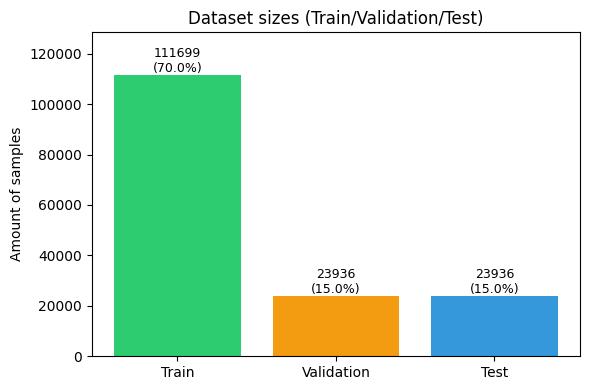

In [111]:
def plot_split_sizes(train_len, val_len, test_len):
    labels = ['Train', 'Validation', 'Test']
    sizes = [train_len, val_len, test_len]
    total = sum(sizes)
    percentages = [(s / total) * 100 for s in sizes]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, sizes, color=['#2ecc71', '#f39c12', '#3498db'])
    plt.ylabel('Amount of samples')
    plt.title('Dataset sizes (Train/Validation/Test)')

    for bar, size, percent in zip(bars, sizes, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{size}\n({percent:.1f}%)',
                 ha='center', va='bottom', fontsize=9)

    plt.ylim(0, max(sizes) * 1.15)
    plt.tight_layout()
    plt.show()

plot_split_sizes(len(train_df), len(val_df), len(test_df))

# Dataloaders

In [112]:
print("\n--- Creating DataLoaders ---")
dataloaders = {}

BATCH_SIZE = 32
GLOVE_MAX_LEN = 150

# 1. TF-IDF DataLoaders (for Logistic Regression)
collate_tfidf_with_vectorizer = partial(collate_fn_tfidf, vectorizer=tfidf_vectorizer)
dataloaders['tfidf'] = {
    'train': DataLoader(train_dataset_base, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_tfidf_with_vectorizer),
    'val': DataLoader(val_dataset_base, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_tfidf_with_vectorizer),
    'test': DataLoader(test_dataset_base, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_tfidf_with_vectorizer)
}
print("DataLoaders for TF-IDF created.")

# 2. GloVe DataLoaders
# GloVe average (for Logistic Regression)
collate_glove_avg_with_helper = partial(collate_fn_glove_avg, glove_helper=glove_helper)
dataloaders['glove_avg'] = {
    'train': DataLoader(train_dataset_base, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_glove_avg_with_helper),
    'val': DataLoader(val_dataset_base, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_glove_avg_with_helper),
    'test': DataLoader(test_dataset_base, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_glove_avg_with_helper)
}
print("DataLoaders for GloVe average created.")

# GloVe sequences (for LSTM)
collate_glove_seq_with_helper = partial(collate_fn_glove_seq, glove_helper=glove_helper, max_len=GLOVE_MAX_LEN)
dataloaders['glove_seq'] = {
    'train': DataLoader(train_dataset_base, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_glove_seq_with_helper),
    'val': DataLoader(val_dataset_base, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_glove_seq_with_helper),
    'test': DataLoader(test_dataset_base, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_glove_seq_with_helper)
}
print("DataLoaders for GloVe sequences created.")


# 3. BERT DataLoaders (for BERT fine-tuning)
# no collate_fn, Dataset already returns tensors
dataloaders['bert'] = {
    'train': DataLoader(train_dataset_bert, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset_bert, batch_size=BATCH_SIZE, shuffle=False),
    'test': DataLoader(test_dataset_bert, batch_size=BATCH_SIZE, shuffle=False)
}
print("DataLoaders for BERT created.")


--- Creating DataLoaders ---
DataLoaders for TF-IDF created.
DataLoaders for GloVe average created.
DataLoaders for GloVe sequences created.
DataLoaders for BERT created.


In [113]:
print("\nTF-IDF example:")
example_batch_tfidf = next(iter(dataloaders['tfidf']['train']))
print("Keys:", example_batch_tfidf.keys())
print("Features:", example_batch_tfidf['features'].shape)
print("Labels:", example_batch_tfidf['labels'].shape)

print("\nGloVe sequence example:")
example_batch_glove_seq = next(iter(dataloaders['glove_seq']['train']))
print("Keys:", example_batch_glove_seq.keys())
print("Sequences:", example_batch_glove_seq['sequences'].shape)
print("Lengths:", example_batch_glove_seq['lengths'].shape)
print("Labels:", example_batch_glove_seq['labels'].shape)

print("\nBERT example:")
example_batch_bert = next(iter(dataloaders['bert']['train']))
print("Keys:", example_batch_bert.keys())
print("Input_ids:", example_batch_bert['input_ids'].shape)
print("Attention_mask:", example_batch_bert['attention_mask'].shape)
print("Labels:", example_batch_bert['labels'].shape)
# print("ID:", example_batch_bert['id'])


TF-IDF example:
Keys: dict_keys(['id', 'features', 'labels'])
Features: torch.Size([32, 20000])
Labels: torch.Size([32, 6])

GloVe sequence example:
Keys: dict_keys(['id', 'sequences', 'lengths', 'labels'])
Sequences: torch.Size([32, 150, 100])
Lengths: torch.Size([32])
Labels: torch.Size([32, 6])

BERT example:
Keys: dict_keys(['id', 'raw_text', 'input_ids', 'attention_mask', 'labels'])
Input_ids: torch.Size([32, 128])
Attention_mask: torch.Size([32, 128])
Labels: torch.Size([32, 6])


# Training

## Logistic Regression

In [114]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim: int, num_labels: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_labels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape [batch_size, input_dim].
        Returns:
            torch.Tensor: shape [batch_size, num_labels].
        """
        return self.linear(x)

## Bi-LSTM

In [115]:
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, num_labels: int,
                 num_layers: int = 1, dropout: float = 0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer: batch_first=True expects [batch_size, seq_len, embedding_dim]
        # dropout applied between layers of LSTM, if num_layers > 1
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # Linear layer for classification
        # Вхід: hidden_dim * 2 (cause bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.dropout_layer = nn.Dropout(dropout) # Dropout before last layer

    def forward(self, sequences: torch.Tensor, lengths: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            sequences (torch.Tensor): shape [batch_size, seq_len, embedding_dim].
            lengths (Optional[torch.Tensor]): Real lengths before padding (for pack_padded_sequence).
                                               shape [batch_size]. If None, no packing is used.
        Returns:
            torch.Tensor: logits, shape [batch_size, num_labels].
        """
        batch_size = sequences.size(0)

        if lengths is not None:
             lengths_cpu = lengths.cpu()
             packed_input = pack_padded_sequence(sequences, lengths_cpu, batch_first=True, enforce_sorted=False)
             packed_output, (hidden, cell) = self.lstm(packed_input)
             # hidden - shape: [num_layers*2, batch_size, hidden_dim]
        else:
             lstm_out, (hidden, cell) = self.lstm(sequences)
             # lstm_out shape: [batch_size, seq_len, hidden_dim * 2]
             # hidden shape: [num_layers*2, batch_size, hidden_dim]

        # Output aggregation:
        # hidden shape: [num_layers * num_directions, batch_size, hidden_size]
        last_hidden_fwd = hidden[-2, :, :]
        last_hidden_bwd = hidden[-1, :, :]
        concatenated_hidden = torch.cat((last_hidden_fwd, last_hidden_bwd), dim=1)
        # concatenated_hidden shape: [batch_size, hidden_dim * 2]

        dropped_output = self.dropout_layer(concatenated_hidden)
        logits = self.fc(dropped_output) # Shape: [batch_size, num_labels]

        return logits

## Helper function

In [116]:
def get_predictions(model: nn.Module, data_loader: DataLoader, device: torch.device) -> Dict[str, np.ndarray]:
    """
    Returns:
        Dict[str, np.ndarray]:
            'ids': ids or indexes.
            'predictions': shape [n_samples, n_labels].
            'true_labels': shape [n_samples, n_labels].
    """
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_ids = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Calculating predictions"):
            labels = batch['labels'].to(device)
            if 'id' in batch:
                 ids = batch['id']
            else:
                 ids = list(range(len(labels)))

            if 'features' in batch: # LogReg (TF-IDF, GloVe Avg)
                inputs = batch['features'].to(device)
                outputs = model(inputs)
            elif 'sequences' in batch: # LSTM (GloVe Seq)
                inputs = batch['sequences'].to(device)
                lengths = batch.get('lengths') 
                if lengths is not None:
                    lengths = lengths.to(device)
                outputs = model(inputs, lengths)
            elif 'input_ids' in batch: # BERT
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                if hasattr(outputs, 'logits'):
                     outputs = outputs.logits
            else:
                raise ValueError("Unknown input type in DataLoader.")

            probs = torch.sigmoid(outputs)

            all_predictions.append(probs.detach().cpu().numpy())
            all_true_labels.append(labels.detach().cpu().numpy())
            all_ids.extend(ids)

    final_predictions = np.concatenate(all_predictions, axis=0)
    final_true_labels = np.concatenate(all_true_labels, axis=0)

    return {
        'ids': all_ids,
        'predictions': final_predictions,
        'true_labels': final_true_labels
    }

## Train function

In [ ]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                optimizer: optim.Optimizer,
                criterion: nn.Module,
                num_epochs: int,
                device: torch.device,
                model_name: str = "Model") -> Dict[str, np.ndarray]:
    model.to(device)
    history = defaultdict(list)

    print(f"\n--- Start training: {model_name} ---")
    start_time_total = time.time()

    for epoch in range(num_epochs):
        start_time_epoch = time.time()
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train
        model.train()
        running_loss_train = 0.0
        train_iterator = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")

        for batch in train_iterator:
            labels = batch['labels'].to(device)
            optimizer.zero_grad()

            if 'features' in batch:
                inputs = batch['features'].to(device)
                outputs = model(inputs)
            elif 'sequences' in batch:
                inputs = batch['sequences'].to(device)
                lengths = batch.get('lengths')
                if lengths is not None:
                    lengths = lengths.to(device)
                outputs = model(inputs, lengths)
            elif 'input_ids' in batch:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                if hasattr(outputs, 'logits'):
                     outputs = outputs.logits
            else:
                 raise ValueError("Unknown input type DataLoader.")

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * labels.size(0)
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss_train)


        # Validate
        model.eval()
        running_loss_val = 0.0
        val_iterator = tqdm(val_loader, desc=f"Validating epoch {epoch + 1}")

        with torch.no_grad():
            for batch in val_iterator:
                labels = batch['labels'].to(device)

                if 'features' in batch:
                    inputs = batch['features'].to(device)
                    outputs = model(inputs)
                elif 'sequences' in batch:
                    inputs = batch['sequences'].to(device)
                    lengths = batch.get('lengths')
                    if lengths is not None:
                         lengths = lengths.to(device)
                    outputs = model(inputs, lengths)
                elif 'input_ids' in batch:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    if hasattr(outputs, 'logits'):
                         outputs = outputs.logits
                else:
                    raise ValueError("Unkonwn input type DataLoader.")

                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * labels.size(0)
                val_iterator.set_postfix(loss=loss.item())


        epoch_loss_val = running_loss_val / len(val_loader.dataset)
        history['val_loss'].append(epoch_loss_val)

        epoch_duration = time.time() - start_time_epoch
        print(f"Epoch {epoch + 1} finished in {epoch_duration:.2f}s.")
        print(f"  Train loss: {epoch_loss_train:.4f}")
        print(f"  Validation loss: {epoch_loss_val:.4f}")

        # early stopping?

    total_training_time = time.time() - start_time_total
    print(f"\n--- Training {model_name} finished in {total_training_time:.2f}s. ---")

    print("\nFinal predictions...")
    final_val_predictions = get_predictions(model, val_loader, device)

    if not os.path.exists("models"):
        os.makedirs("models", exist_ok=True)

    save_path = f"models/{model_name.replace(' ', '_').lower()}_final.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved: {save_path}")

    return final_val_predictions

<>:17: SyntaxWarning:

invalid escape sequence '\E'

<>:17: SyntaxWarning:

invalid escape sequence '\E'

C:\Users\user\AppData\Local\Temp\ipykernel_99272\541836168.py:17: SyntaxWarning:

invalid escape sequence '\E'



## Training process

In [118]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 5
HIDDEN_DIM_LSTM = 128
NUM_LABELS = len(label_cols)

criterion = nn.BCEWithLogitsLoss()

validation_results = {}

In [119]:
# TF-IDF + Logistic Regression
# input_dim_tfidf = dataloaders['tfidf']['train'].collate_fn.keywords['vectorizer'].max_features
input_dim_tfidf = tfidf_vectorizer.max_features

log_reg_model_tfidf = LogisticRegressionModel(input_dim=input_dim_tfidf, num_labels=NUM_LABELS)
optimizer_lr_tfidf = optim.Adam(log_reg_model_tfidf.parameters(), lr=LEARNING_RATE)

val_preds_lr_tfidf = train_model(
    model=log_reg_model_tfidf,
    train_loader=dataloaders['tfidf']['train'],
    val_loader=dataloaders['tfidf']['val'],
    optimizer=optimizer_lr_tfidf,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device,
    model_name="LogReg_TFIDF"
)
validation_results['logreg_tfidf'] = val_preds_lr_tfidf


--- Start training: LogReg_TFIDF ---
\Epoch 1/5


Training Epoch 1:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 1:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 1 finished in 35.62s.
  Train loss: 0.5425
  Validation loss: 0.4197
\Epoch 2/5


Training Epoch 2:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 2:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 2 finished in 32.40s.
  Train loss: 0.3422
  Validation loss: 0.2758
\Epoch 3/5


Training Epoch 3:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 3:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3 finished in 29.13s.
  Train loss: 0.2351
  Validation loss: 0.1988
\Epoch 4/5


Training Epoch 4:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 4:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4 finished in 27.04s.
  Train loss: 0.1777
  Validation loss: 0.1578
\Epoch 5/5


Training Epoch 5:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 5:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5 finished in 28.30s.
  Train loss: 0.1469
  Validation loss: 0.1358

--- Training LogReg_TFIDF finished in 152.48s. ---

Final predictions...


Calculating predictions:   0%|          | 0/748 [00:00<?, ?it/s]

Model saved: models/logreg_tfidf_final.pth


In [120]:
# GloVe Average + Logistic Regression
input_dim_glove = glove_helper.get_embedding_dim()
log_reg_model_glove = LogisticRegressionModel(input_dim=input_dim_glove, num_labels=NUM_LABELS)
optimizer_lr_glove = optim.Adam(log_reg_model_glove.parameters(), lr=LEARNING_RATE)

val_preds_lr_glove = train_model(
    model=log_reg_model_glove,
    train_loader=dataloaders['glove_avg']['train'],
    val_loader=dataloaders['glove_avg']['val'],
    optimizer=optimizer_lr_glove,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device,
    model_name="LogReg_GloVeAvg"
)
validation_results['logreg_glove_avg'] = val_preds_lr_glove


--- Start training: LogReg_GloVeAvg ---
\Epoch 1/5


Training Epoch 1:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 1:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 1 finished in 21.34s.
  Train loss: 0.2318
  Validation loss: 0.1316
\Epoch 2/5


Training Epoch 2:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 2:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 2 finished in 21.60s.
  Train loss: 0.1223
  Validation loss: 0.1135
\Epoch 3/5


Training Epoch 3:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 3:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3 finished in 21.67s.
  Train loss: 0.1116
  Validation loss: 0.1075
\Epoch 4/5


Training Epoch 4:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 4:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4 finished in 21.46s.
  Train loss: 0.1070
  Validation loss: 0.1042
\Epoch 5/5


Training Epoch 5:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 5:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5 finished in 21.41s.
  Train loss: 0.1040
  Validation loss: 0.1018

--- Training LogReg_GloVeAvg finished in 107.48s. ---

Final predictions...


Calculating predictions:   0%|          | 0/748 [00:00<?, ?it/s]

Model saved: models/logreg_gloveavg_final.pth


In [121]:
# GloVe Sequences + Bi-LSTM
embedding_dim_glove = glove_helper.get_embedding_dim()
bilstm_model_glove = BiLSTMModel(
    embedding_dim=embedding_dim_glove,
    hidden_dim=HIDDEN_DIM_LSTM,
    num_labels=NUM_LABELS,
    num_layers=1, # or 2
    dropout=0.3
)
optimizer_bilstm_glove = optim.Adam(bilstm_model_glove.parameters(), lr=LEARNING_RATE)

val_preds_bilstm_glove = train_model(
    model=bilstm_model_glove,
    train_loader=dataloaders['glove_seq']['train'],
    val_loader=dataloaders['glove_seq']['val'],
    optimizer=optimizer_bilstm_glove,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device,
    model_name="BiLSTM_GloVeSeq"
)
validation_results['bilstm_glove_seq'] = val_preds_bilstm_glove


--- Start training: BiLSTM_GloVeSeq ---
\Epoch 1/5


Training Epoch 1:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 1:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 1 finished in 78.86s.
  Train loss: 0.1047
  Validation loss: 0.0772
\Epoch 2/5


Training Epoch 2:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 2:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 2 finished in 76.79s.
  Train loss: 0.0778
  Validation loss: 0.0782
\Epoch 3/5


Training Epoch 3:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 3:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3 finished in 75.70s.
  Train loss: 0.0709
  Validation loss: 0.0653
\Epoch 4/5


Training Epoch 4:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 4:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4 finished in 76.45s.
  Train loss: 0.0635
  Validation loss: 0.0611
\Epoch 5/5


Training Epoch 5:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 5:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5 finished in 76.69s.
  Train loss: 0.0604
  Validation loss: 0.0585

--- Training BiLSTM_GloVeSeq finished in 384.49s. ---

Final predictions...


Calculating predictions:   0%|          | 0/748 [00:00<?, ?it/s]

Model saved: models/bilstm_gloveseq_final.pth


In [ ]:
print(f"Results for: {list(validation_results.keys())}")

# validation_results = {
#     'logreg_tfidf': {'ids': [...], 'predictions': ndarray, 'true_labels': ndarray},
#     'logreg_glove_avg': {'ids': [...], 'predictions': ndarray, 'true_labels': ndarray},
#     'bilstm_glove_seq': {'ids': [...], 'predictions': ndarray, 'true_labels': ndarray},
#     # ... other models
# }


# if 'bilstm_glove_seq' in validation_results:
#     bilstm_preds = validation_results['bilstm_glove_seq']['predictions']
#     bilstm_true = validation_results['bilstm_glove_seq']['true_labels']
#     print(f"BiLSTM: {bilstm_preds.shape}")
#     print(f"BiLSTM: {bilstm_true.shape}")

Results for: ['logreg_tfidf', 'logreg_glove_avg', 'bilstm_glove_seq']


## BERT fine-tuning

In [132]:
BERT_MODEL_NAME = 'bert-base-uncased'
BERT_MAX_LEN = 128
BERT_LEARNING_RATE = 3e-5

In [ ]:
print("\n--- Model 4: BERT Fine-tuning ---")
print(f"Using pre-trained model: {BERT_MODEL_NAME}")
print(f"Using Learning Rate: {BERT_LEARNING_RATE}")

try:
    if 'bert' not in dataloaders:
        raise KeyError("DataLoader 'bert' not found. Please ensure BertToxicCommentDataset and its DataLoaders were created.")

    bert_model = AutoModelForSequenceClassification.from_pretrained(
        BERT_MODEL_NAME,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification" # Important for correct head setup!
    )

    optimizer_bert = optim.AdamW(bert_model.parameters(), lr=BERT_LEARNING_RATE)

    val_preds_bert = train_model(
        model=bert_model,
        train_loader=dataloaders['bert']['train'],
        val_loader=dataloaders['bert']['val'],
        optimizer=optimizer_bert,
        criterion=criterion,
        num_epochs=NUM_EPOCHS,
        device=device,
        model_name="BERT_FineTuned"
    )
    validation_results['bert'] = val_preds_bert

except KeyError as e:
    print(f"Error: {e}. Skipping BERT fine-tuning.")
except ImportError:
    print("Error: 'transformers' library not found. Please install it (`pip install transformers`). Skipping BERT fine-tuning.")
except Exception as e:
    print(f"An error occurred during BERT fine-tuning: {e}")

print("\n--- Potentially finished BERT training ---")
print(f"Results available for: {list(validation_results.keys())}")


--- Model 4: BERT Fine-tuning ---
Using pre-trained model: bert-base-uncased
Using Learning Rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Start training: BERT_FineTuned ---
\Epoch 1/5


Training Epoch 1:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 1:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 1 finished in 494.07s.
  Train loss: 0.0507
  Validation loss: 0.0405
\Epoch 2/5


Training Epoch 2:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 2:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 2 finished in 467.23s.
  Train loss: 0.0342
  Validation loss: 0.0406
\Epoch 3/5


Training Epoch 3:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 3:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 3 finished in 451.25s.
  Train loss: 0.0269
  Validation loss: 0.0428
\Epoch 4/5


Training Epoch 4:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 4:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 4 finished in 449.08s.
  Train loss: 0.0211
  Validation loss: 0.0469
\Epoch 5/5


Training Epoch 5:   0%|          | 0/3491 [00:00<?, ?it/s]

Validating epoch 5:   0%|          | 0/748 [00:00<?, ?it/s]

Epoch 5 finished in 449.33s.
  Train loss: 0.0158
  Validation loss: 0.0547

--- Training BERT_FineTuned finished in 2310.95s. ---

Final predictions...


Calculating predictions:   0%|          | 0/748 [00:00<?, ?it/s]

Model saved: models/bert_finetuned_final.pth

--- Potentially finished BERT training ---
Results available for: ['logreg_tfidf', 'logreg_glove_avg', 'bilstm_glove_seq', 'bert']

=== Starting Model Evaluation (including BERT) ===


# Evaluation

In [123]:
def evaluate_model(results: Dict[str, np.ndarray],
                   label_names: List[str],
                   threshold: float = 0.5) -> Dict[str, float]:
    y_true = results['true_labels']
    y_pred_proba = results['predictions']

    if y_true.shape != y_pred_proba.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred_proba {y_pred_proba.shape}")

    print(f"\n--- Evaluation Metrics (Threshold = {threshold}) ---")

    y_pred_binary = (y_pred_proba >= threshold).astype(int)

    metrics_summary = {}

    # 1. Classification Report (Precision, Recall, F1 per label and averages)
    print("\nClassification Report:")
    # zero_division=0 handles cases where a class has no true samples or no predicted samples
    report = classification_report(y_true, y_pred_binary, target_names=label_names, zero_division=0, digits=3)
    print(report)

    # Extract key averages from the report (requires parsing or recalculating)
    # We'll recalculate for clarity using roc_auc_score and average_precision_score later
    # For F1, let's calculate macro and micro F1 directly for the summary
    f1_micro = f1_score(y_true, y_pred_binary, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred_binary, average='weighted', zero_division=0)
    f1_samples = f1_score(y_true, y_pred_binary, average='samples', zero_division=0)

    metrics_summary['f1_micro'] = f1_micro
    metrics_summary['f1_macro'] = f1_macro
    metrics_summary['f1_weighted'] = f1_weighted
    metrics_summary['f1_samples'] = f1_samples


    # 2. Subset Accuracy (Exact Match Ratio)
    subset_acc = accuracy_score(y_true, y_pred_binary)
    print(f"\nSubset Accuracy (Exact Match Ratio): {subset_acc:.4f}")
    metrics_summary['subset_accuracy'] = subset_acc

    # 3. Hamming Loss
    h_loss = hamming_loss(y_true, y_pred_binary)
    print(f"Hamming Loss (Lower is better): {h_loss:.4f}")
    metrics_summary['hamming_loss'] = h_loss

    # --- Threshold-Independent Metrics ---
    print("\n--- Threshold-Independent Metrics ---")

    # 4. ROC AUC
    try:
        roc_auc_micro = roc_auc_score(y_true, y_pred_proba, average='micro')
        roc_auc_macro = roc_auc_score(y_true, y_pred_proba, average='macro')
        roc_auc_weighted = roc_auc_score(y_true, y_pred_proba, average='weighted')
        # Per-label ROC AUC
        roc_auc_per_label = roc_auc_score(y_true, y_pred_proba, average=None)

        print(f"ROC AUC (Micro Avg):   {roc_auc_micro:.4f}")
        print(f"ROC AUC (Macro Avg):   {roc_auc_macro:.4f}")
        print(f"ROC AUC (Weighted Avg):{roc_auc_weighted:.4f}")
        metrics_summary['roc_auc_micro'] = roc_auc_micro
        metrics_summary['roc_auc_macro'] = roc_auc_macro
        metrics_summary['roc_auc_weighted'] = roc_auc_weighted

        print("ROC AUC (Per Label):")
        for i, label in enumerate(label_names):
            print(f"  - {label}: {roc_auc_per_label[i]:.4f}")
            metrics_summary[f'roc_auc_{label}'] = roc_auc_per_label[i]

    except ValueError as e:
        print(f"Could not calculate ROC AUC. Reason: {e}")
        print("  (This can happen if a class has only one value in y_true in the evaluated set)")

    # 5. Average Precision Score (PR AUC)
    try:
        aps_micro = average_precision_score(y_true, y_pred_proba, average='micro')
        aps_macro = average_precision_score(y_true, y_pred_proba, average='macro')
        aps_weighted = average_precision_score(y_true, y_pred_proba, average='weighted')
        # Per-label APS
        aps_per_label = average_precision_score(y_true, y_pred_proba, average=None)

        print(f"\nAverage Precision Score (Micro Avg):   {aps_micro:.4f}")
        print(f"Average Precision Score (Macro Avg):   {aps_macro:.4f}")
        print(f"Average Precision Score (Weighted Avg):{aps_weighted:.4f}")
        metrics_summary['aps_micro'] = aps_micro
        metrics_summary['aps_macro'] = aps_macro
        metrics_summary['aps_weighted'] = aps_weighted

        print("Average Precision Score (Per Label):")
        for i, label in enumerate(label_names):
             print(f"  - {label}: {aps_per_label[i]:.4f}")
             metrics_summary[f'aps_{label}'] = aps_per_label[i]

    except ValueError as e:
        print(f"\nCould not calculate Average Precision Score. Reason: {e}")

    print("-" * 50)
    return metrics_summary

In [130]:
def plot_evaluation_curves(results: Dict[str, np.ndarray], label_names: List[str], model_name: str = ""):
    """
    Plots ROC and Precision-Recall curves side-by-side in one row
    for each label and the micro-average.

    Args:
        results (Dict[str, np.ndarray]): Dictionary containing 'predictions' (probabilities)
                                         and 'true_labels' (binary ground truth).
        label_names (List[str]): List of names for the labels corresponding to columns.
        model_name (str): Name of the model for the title.
    """
    y_true = results['true_labels']
    y_pred_proba = results['predictions']
    n_classes = len(label_names)

    # --- Create Figure and Subplots (1 row, 2 columns) ---
    fig, ax = plt.subplots(1, 2, figsize=(20, 8)) # Increase figure size for two plots

    # --- Plot 1: ROC Curves (on ax[0]) ---
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC curve and ROC area for each class
    for i in range(n_classes):
        try:
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        except ValueError:
             print(f"   Skipping ROC curve for label '{label_names[i]}' due to only one class present in y_true.")
             fpr[i], tpr[i], roc_auc[i] = None, None, None

    # Calculate micro-average ROC curve and ROC area
    try:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    except ValueError:
        print("   Skipping micro-average ROC curve due to issues.")
        fpr["micro"], tpr["micro"], roc_auc["micro"] = None, None, None

    # Plot micro-average ROC curve if available
    if fpr.get("micro") is not None:
        ax[0].plot(fpr["micro"], tpr["micro"],
                   label=f'Micro-average ROC (area = {roc_auc["micro"]:0.3f})',
                   color='deeppink', linestyle=':', linewidth=4)

    # Plot per-label ROC curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
         if fpr.get(i) is not None:
            ax[0].plot(fpr[i], tpr[i], color=color, lw=2,
                       label=f'ROC {label_names[i]} (area = {roc_auc[i]:0.3f})')

    # Plot diagonal line and set labels/title for ROC plot
    ax[0].plot([0, 1], [0, 1], 'k--', lw=2)
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC)')
    ax[0].legend(loc="lower right", fontsize='small')
    ax[0].grid(alpha=0.3)

    # --- Plot 2: Precision-Recall Curves (on ax[1]) ---
    precision = dict()
    recall = dict()
    average_precision = dict()

    # Calculate micro-average Precision-Recall curve and AP
    try:
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred_proba.ravel())
        average_precision["micro"] = average_precision_score(y_true, y_pred_proba, average="micro")
    except ValueError:
        print("   Skipping micro-average PR curve due to issues.")
        precision["micro"], recall["micro"], average_precision["micro"] = None, None, None

    # Calculate Precision-Recall curve and AP for each class
    for i in range(n_classes):
         try:
            precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
            average_precision[i] = average_precision_score(y_true[:, i], y_pred_proba[:, i])
         except ValueError:
             print(f"   Skipping PR curve for label '{label_names[i]}' due to issues.")
             precision[i], recall[i], average_precision[i] = None, None, None

    # Plot micro-average PR curve if available
    if precision.get("micro") is not None:
        ax[1].plot(recall["micro"], precision["micro"],
                   label=f'Micro-average PR (AP = {average_precision["micro"]:0.3f})',
                   color='navy', linestyle=':', linewidth=4)

    # Plot per-label PR curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']) # Reset color cycle
    for i, color in zip(range(n_classes), colors):
        if precision.get(i) is not None:
            ax[1].plot(recall[i], precision[i], color=color, lw=2,
                       label=f'PR {label_names[i]} (AP = {average_precision[i]:0.3f})')

    # Set labels/title for PR plot
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    ax[1].legend(loc="lower left", fontsize='small')
    ax[1].grid(alpha=0.3)

    # --- Final Figure Adjustments ---
    fig.suptitle(f'Evaluation Curves - {model_name}', fontsize=16) # Add overall title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent overlap and make space for suptitle
    plt.show()



--- Evaluating Model: logreg_tfidf ---

--- Evaluation Metrics (Threshold = 0.5) ---

Classification Report:
               precision    recall  f1-score   support

        toxic      0.000     0.000     0.000      2227
 severe_toxic      0.000     0.000     0.000       240
      obscene      0.000     0.000     0.000      1243
       threat      0.000     0.000     0.000        85
       insult      0.000     0.000     0.000      1144
identity_hate      0.000     0.000     0.000       204

    micro avg      0.000     0.000     0.000      5143
    macro avg      0.000     0.000     0.000      5143
 weighted avg      0.000     0.000     0.000      5143
  samples avg      0.000     0.000     0.000      5143


Subset Accuracy (Exact Match Ratio): 0.9009
Hamming Loss (Lower is better): 0.0358

--- Threshold-Independent Metrics ---
ROC AUC (Micro Avg):   0.8774
ROC AUC (Macro Avg):   0.8151
ROC AUC (Weighted Avg):0.8434
ROC AUC (Per Label):
  - toxic: 0.8497
  - severe_toxic: 0.8751
  - 

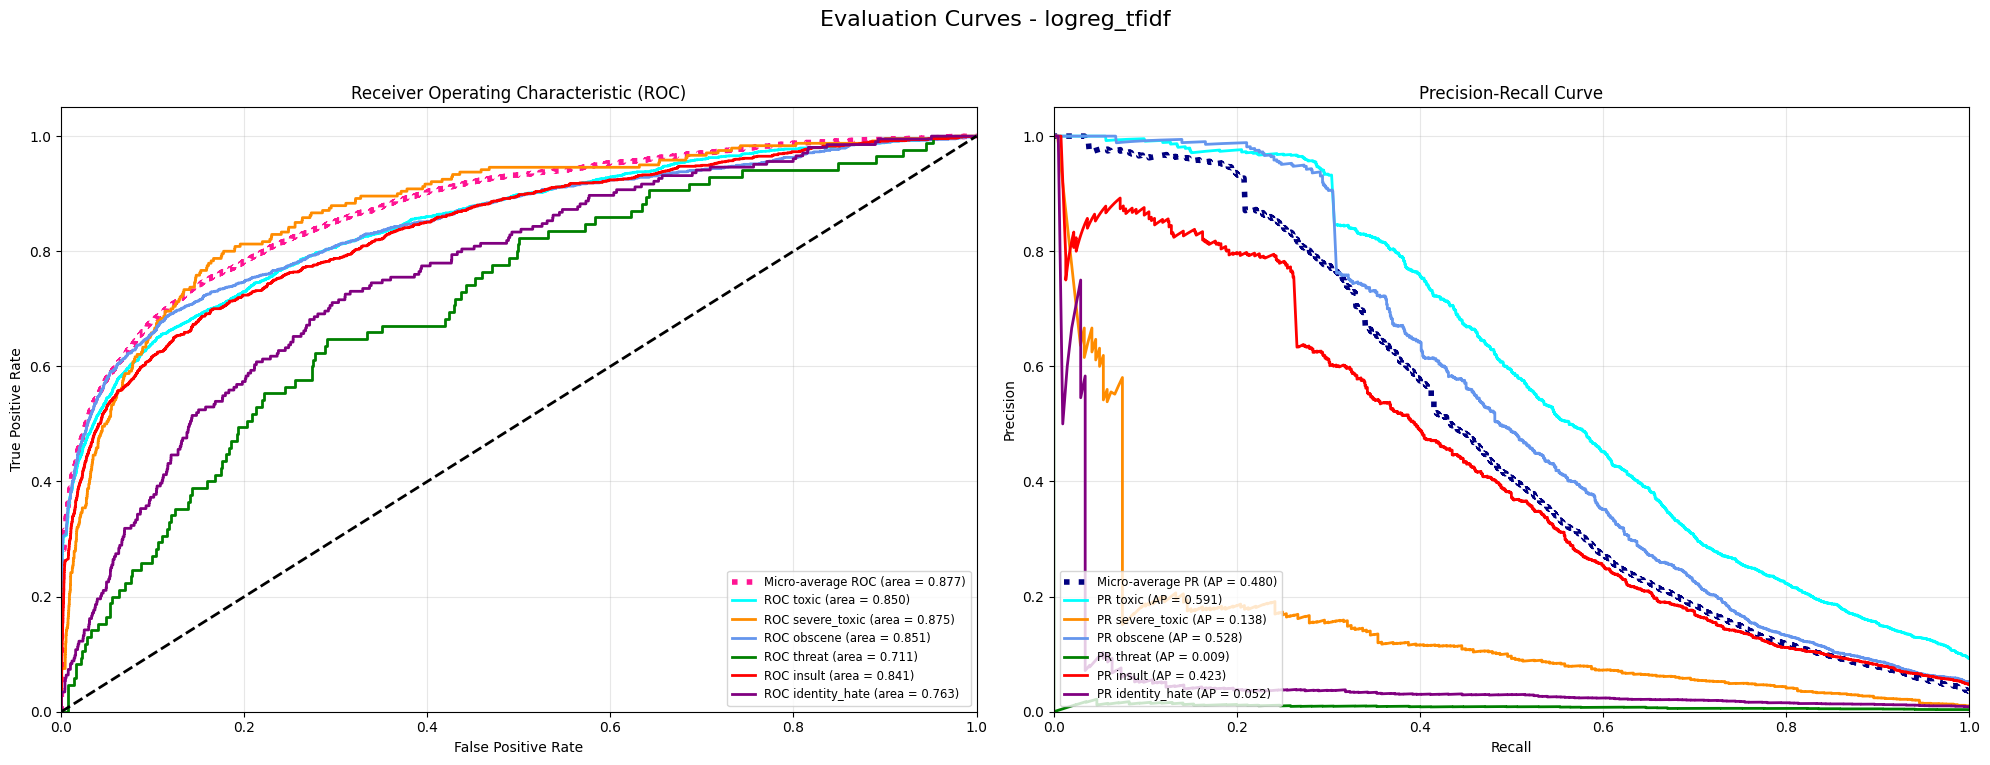



--- Evaluating Model: logreg_glove_avg ---

--- Evaluation Metrics (Threshold = 0.5) ---

Classification Report:
               precision    recall  f1-score   support

        toxic      0.689     0.245     0.362      2227
 severe_toxic      0.175     0.046     0.073       240
      obscene      0.610     0.198     0.299      1243
       threat      0.000     0.000     0.000        85
       insult      0.537     0.163     0.251      1144
identity_hate      0.148     0.020     0.035       204

    micro avg      0.605     0.193     0.293      5143
    macro avg      0.360     0.112     0.170      5143
 weighted avg      0.579     0.193     0.289      5143
  samples avg      0.021     0.016     0.017      5143


Subset Accuracy (Exact Match Ratio): 0.8967
Hamming Loss (Lower is better): 0.0334

--- Threshold-Independent Metrics ---
ROC AUC (Micro Avg):   0.9137
ROC AUC (Macro Avg):   0.8669
ROC AUC (Weighted Avg):0.8943
ROC AUC (Per Label):
  - toxic: 0.8903
  - severe_toxic: 0.9310


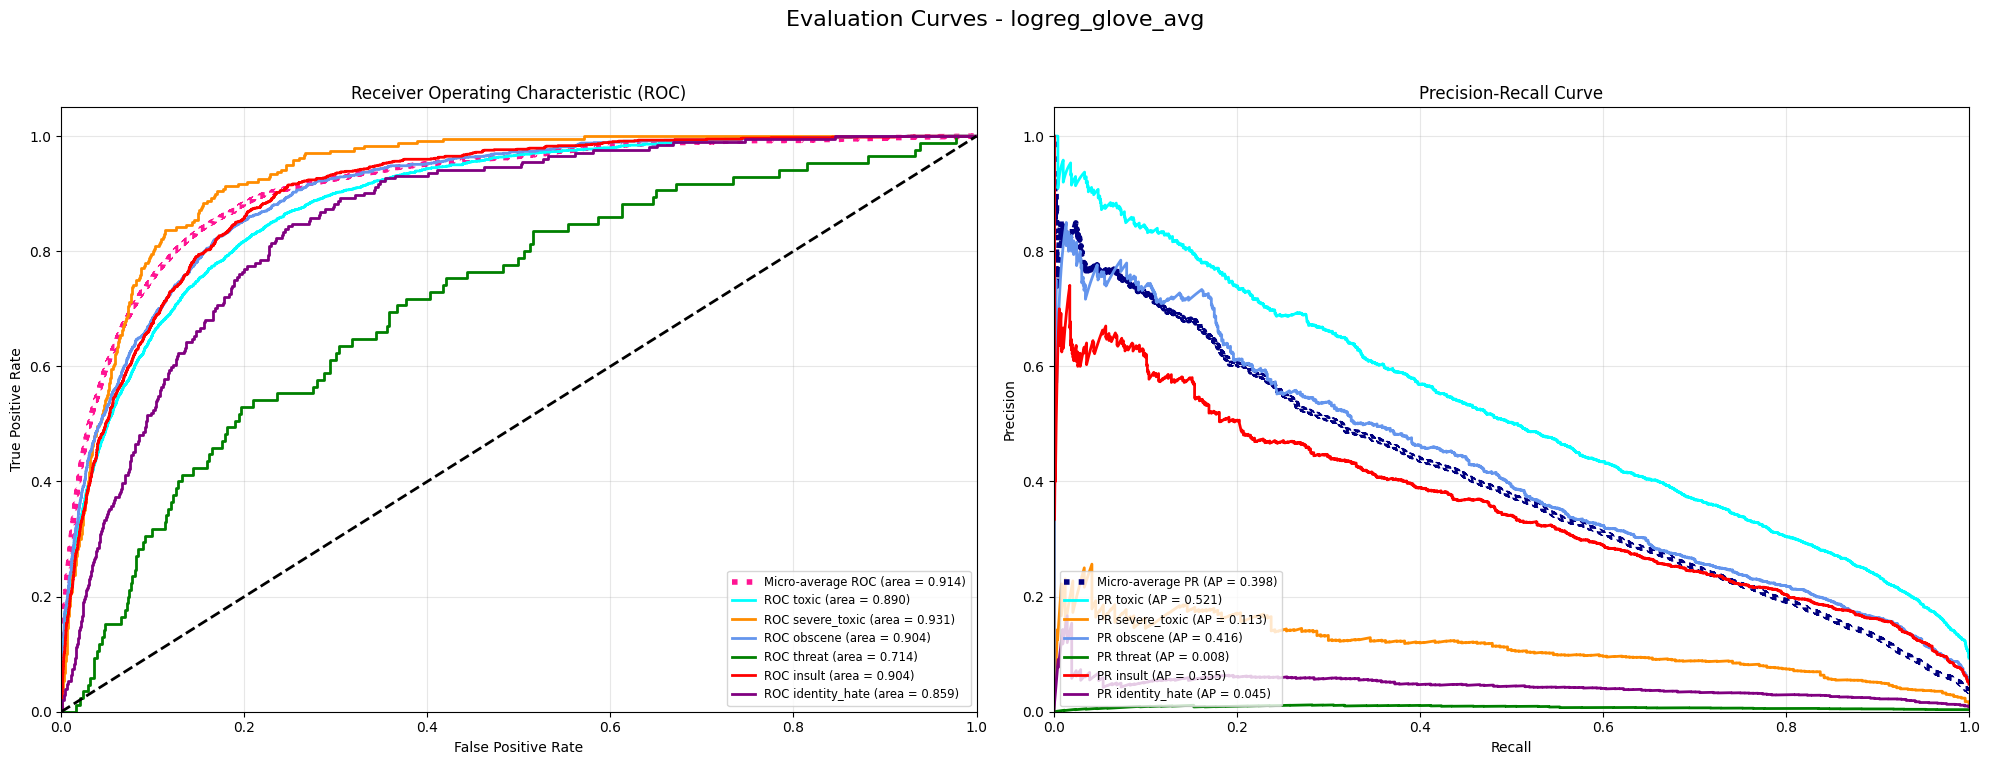



--- Evaluating Model: bilstm_glove_seq ---

--- Evaluation Metrics (Threshold = 0.5) ---

Classification Report:
               precision    recall  f1-score   support

        toxic      0.838     0.620     0.713      2227
 severe_toxic      0.643     0.113     0.191       240
      obscene      0.834     0.656     0.735      1243
       threat      0.000     0.000     0.000        85
       insult      0.727     0.582     0.647      1144
identity_hate      0.000     0.000     0.000       204

    micro avg      0.806     0.562     0.662      5143
    macro avg      0.507     0.329     0.381      5143
 weighted avg      0.756     0.562     0.639      5143
  samples avg      0.053     0.048     0.048      5143


Subset Accuracy (Exact Match Ratio): 0.9151
Hamming Loss (Lower is better): 0.0205

--- Threshold-Independent Metrics ---
ROC AUC (Micro Avg):   0.9761
ROC AUC (Macro Avg):   0.9664
ROC AUC (Weighted Avg):0.9664
ROC AUC (Per Label):
  - toxic: 0.9590
  - severe_toxic: 0.9838


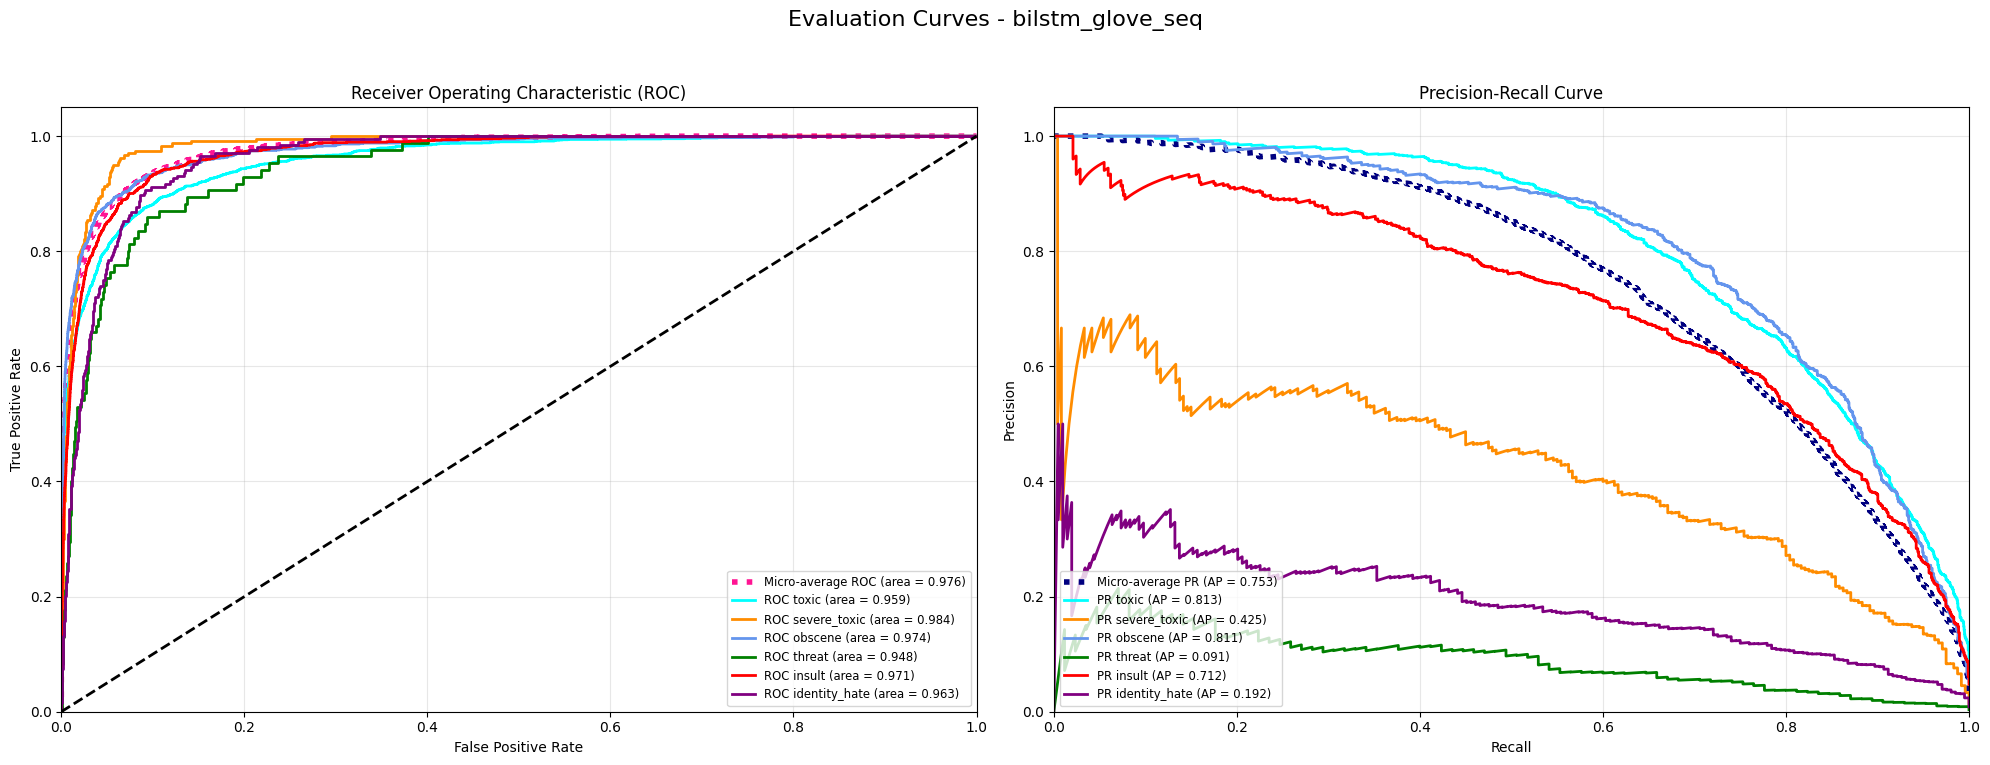



--- Evaluating Model: bert ---

--- Evaluation Metrics (Threshold = 0.5) ---

Classification Report:
               precision    recall  f1-score   support

        toxic      0.827     0.820     0.823      2227
 severe_toxic      0.641     0.350     0.453       240
      obscene      0.863     0.776     0.817      1243
       threat      0.714     0.294     0.417        85
       insult      0.720     0.773     0.745      1144
identity_hate      0.605     0.451     0.517       204

    micro avg      0.796     0.754     0.774      5143
    macro avg      0.728     0.577     0.629      5143
 weighted avg      0.793     0.754     0.768      5143
  samples avg      0.070     0.070     0.067      5143


Subset Accuracy (Exact Match Ratio): 0.9265
Hamming Loss (Lower is better): 0.0158

--- Threshold-Independent Metrics ---
ROC AUC (Micro Avg):   0.9876
ROC AUC (Macro Avg):   0.9844
ROC AUC (Weighted Avg):0.9829
ROC AUC (Per Label):
  - toxic: 0.9799
  - severe_toxic: 0.9846
  - obscene:

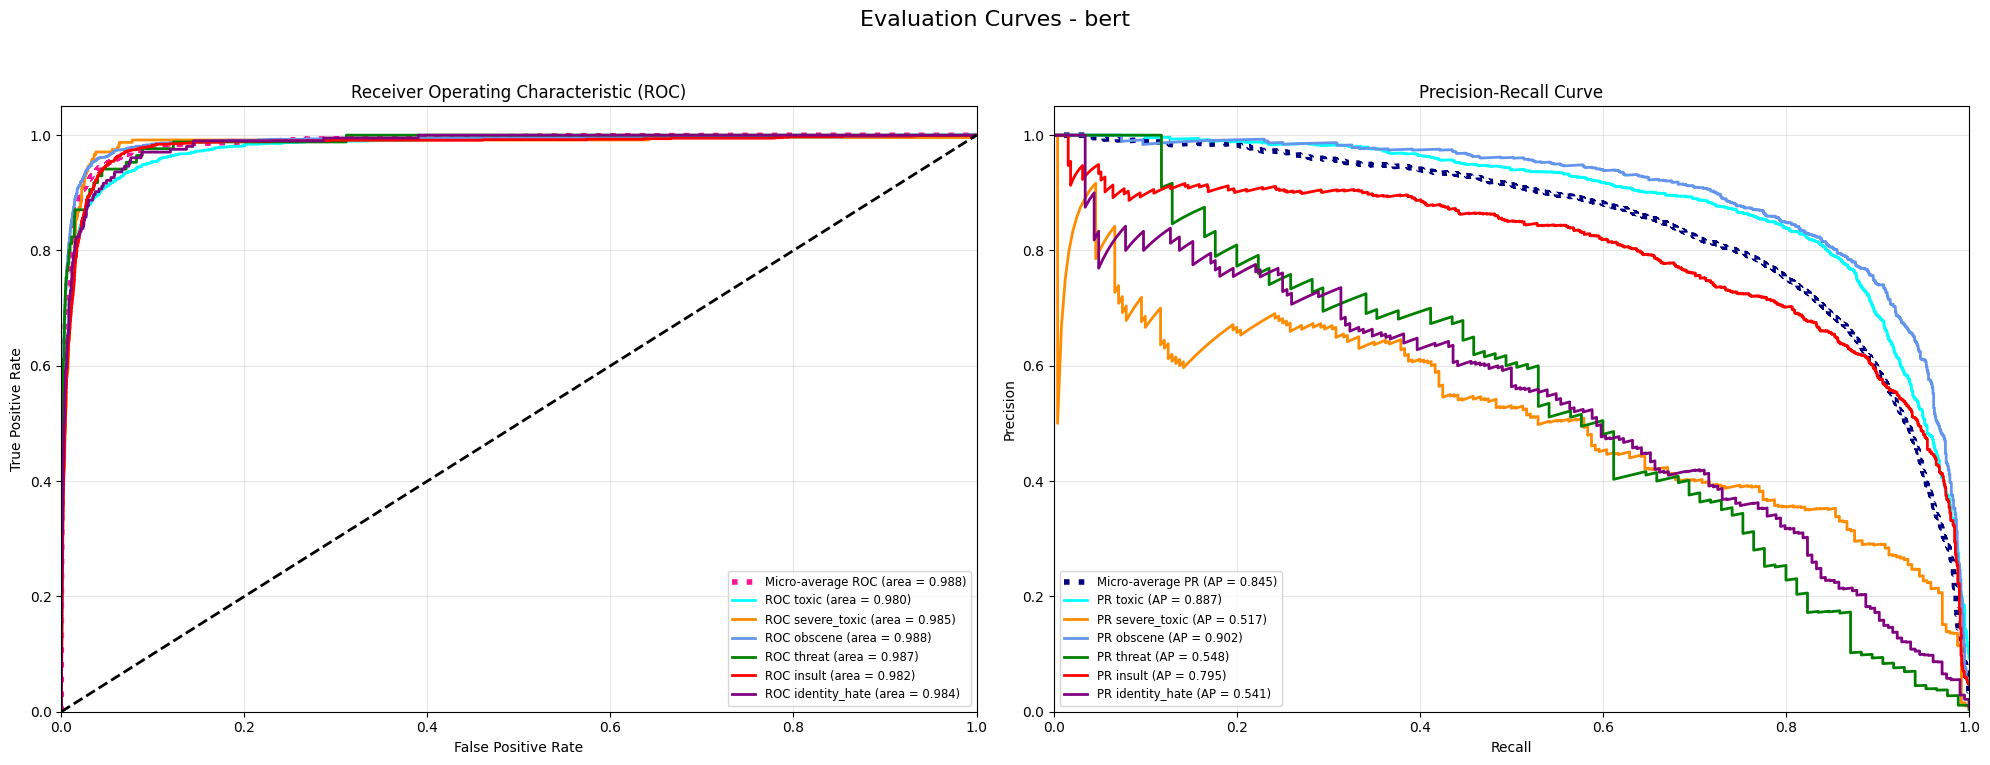

In [139]:
all_model_metrics = {}

for model_key, results_dict in validation_results.items():
    print(f"\n\n--- Evaluating Model: {model_key} ---")
    if results_dict is None or 'predictions' not in results_dict or 'true_labels' not in results_dict:
        print("   Skipping evaluation for this model due to missing results.")
        continue

    # Calculate and print metrics
    metrics = evaluate_model(results_dict, label_names=label_cols, threshold=0.5)
    all_model_metrics[model_key] = metrics

    # --- Optional: Plot ROC and PR curves for this model ---
    print(f"\n   Generating plots for {model_key}...")
    try:
            # plot_roc_curves(results_dict, label_names=label_cols, model_name=model_key)
            # plot_precision_recall_curves(results_dict, label_names=label_cols, model_name=model_key)
            plot_evaluation_curves(results_dict, label_names=label_cols, model_name=model_key)
    except Exception as plot_err:
            print(f"     Could not generate plots for {model_key}. Error: {plot_err}")



--- Model Comparison Summary ---
                  f1_macro  roc_auc_macro  aps_macro  subset_accuracy  \
bert              0.628769       0.984447   0.698516         0.926506   
bilstm_glove_seq  0.380945       0.966432   0.507206         0.915142   
logreg_glove_avg  0.169734       0.866878   0.243001         0.896716   
logreg_tfidf      0.000000       0.815055   0.290184         0.900852   

                  hamming_loss  
bert                  0.015759  
bilstm_glove_seq      0.020522  
logreg_glove_avg      0.033418  
logreg_tfidf          0.035814  


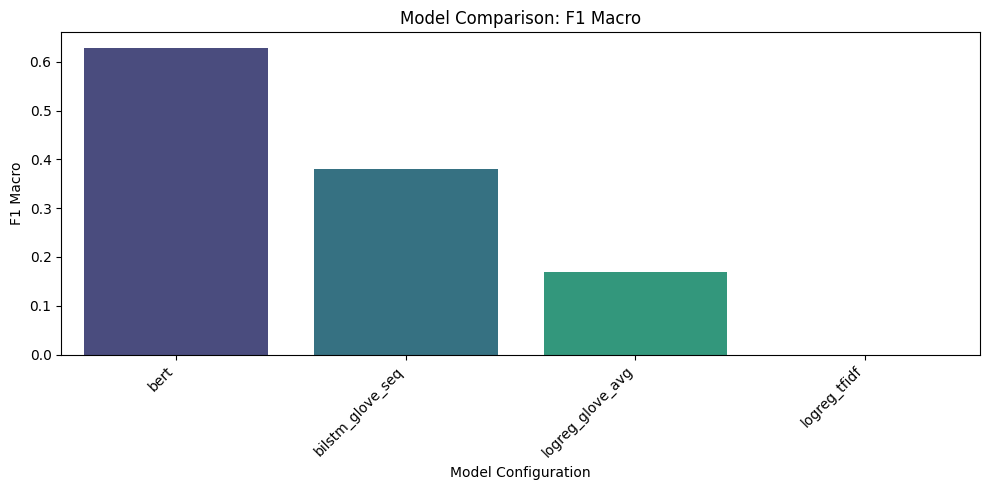

In [141]:
if all_model_metrics:
    print("\n\n--- Model Comparison Summary ---")
    # Select a few key metrics for comparison, e.g., macro averages which treat all classes equally
    comparison_metrics = ['f1_macro', 'roc_auc_macro', 'aps_macro', 'subset_accuracy', 'hamming_loss']
    summary_data = {model: {metric: metrics.get(metric, float('nan')) for metric in comparison_metrics}
                    for model, metrics in all_model_metrics.items()}

    summary_df = pd.DataFrame(summary_data).T # Transpose for models as rows
    summary_df = summary_df.sort_values(by='f1_macro', ascending=False) # Sort by F1 Macro
    print(summary_df)

    # --- Optional: Bar plot comparison ---
    # Select one primary metric for the bar plot
    primary_metric = 'f1_macro'
    if primary_metric in summary_df.columns:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=summary_df.index, y=summary_df[primary_metric], palette='viridis', hue=summary_df.index, legend=False)
        plt.title(f'Model Comparison: {primary_metric.replace("_", " ").title()}')
        plt.ylabel(primary_metric.replace("_", " ").title())
        plt.xlabel('Model Configuration')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Example

In [ ]:
def clean_text_for_inference(text: str) -> str:
    if not isinstance(text, str):
         text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_for_inference(text: str) -> List[str]:
    tokens = text.split()
    tokens = [token for token in tokens if token]
    return tokens

def predict_single(text: str,
                   model: torch.nn.Module,
                   model_type: str, # 'logreg_tfidf', 'logreg_glove_avg', 'bilstm_glove_seq', 'bert'
                   device: torch.device,
                   label_names: List[str],
                   tfidf_vectorizer: Optional[TfidfVectorizer] = None,
                   glove_helper: Optional[GloveHelper] = None,
                   bert_tokenizer: Optional[AutoTokenizer] = None,
                   max_len_glove: int = 150,
                   max_len_bert: int = 128) -> Dict[str, float]:
    model.eval()
    model.to(device)

    processed_input = {}
    model_requires_lengths = False

    if model_type == 'logreg_tfidf':
        if tfidf_vectorizer is None:
            raise ValueError("tfidf_vectorizer is required for model_type 'logreg_tfidf'")
        cleaned = clean_text_for_inference(text)
        vector = tfidf_vectorizer.transform([cleaned]).toarray()
        processed_input['features'] = torch.tensor(vector, dtype=torch.float32)

    elif model_type == 'logreg_glove_avg':
        if glove_helper is None:
            raise ValueError("glove_helper is required for model_type 'logreg_glove_avg'")
        cleaned = clean_text_for_inference(text)
        tokens = tokenize_for_inference(cleaned)
        vector = glove_helper.vectorize_average(tokens)
        processed_input['features'] = torch.tensor(vector, dtype=torch.float32).unsqueeze(0)

    elif model_type == 'bilstm_glove_seq':
        if glove_helper is None:
            raise ValueError("glove_helper is required for model_type 'bilstm_glove_seq'")
        cleaned = clean_text_for_inference(text)
        tokens = tokenize_for_inference(cleaned)
        seq_matrix, length = glove_helper.vectorize_sequence(tokens, max_len=max_len_glove, pad_to_max=True)
        processed_input['sequences'] = torch.tensor(seq_matrix, dtype=torch.float32).unsqueeze(0)
        processed_input['lengths'] = torch.tensor([length], dtype=torch.int64)
        model_requires_lengths = True

    elif model_type == 'bert':
        if bert_tokenizer is None:
            raise ValueError("bert_tokenizer is required for model_type 'bert'")
        encoding = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len_bert,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        processed_input['input_ids'] = encoding['input_ids']
        processed_input['attention_mask'] = encoding['attention_mask']

    else:
        raise ValueError(f"Invalid model_type: {model_type}. Valid options are: "
                         "'logreg_tfidf', 'logreg_glove_avg', 'bilstm_glove_seq', 'bert'")

    with torch.no_grad():
        for key in processed_input:
            processed_input[key] = processed_input[key].to(device)

        if model_type in ['logreg_tfidf', 'logreg_glove_avg']:
            logits = model(processed_input['features'])
        elif model_type == 'bilstm_glove_seq':
            logits = model(processed_input['sequences'], processed_input['lengths'])
        elif model_type == 'bert':
            outputs = model(input_ids=processed_input['input_ids'],
                            attention_mask=processed_input['attention_mask'])
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        else:
             raise ValueError("Invalid model_type during inference step")


        probabilities = torch.sigmoid(logits)
        probs_np = probabilities.squeeze().cpu().numpy()

    if probs_np.shape != (len(label_names),):
         print(f"Warning: Unexpected probability shape {probs_np.shape}. Expected ({len(label_names)},).")
         if probs_np.size == len(label_names):
              probs_np = probs_np.flatten()
         else:
              print("Error: Cannot match probabilities to label names.")
              return {}


    results = {name: float(prob) for name, prob in zip(label_names, probs_np)}
    return results

In [ ]:
# 1. Load model
MODEL_SAVE_PATH = "models/bert_finetuned_final.pth" # Або інший шлях, де збережена модель
# MODEL_SAVE_PATH = "models/logreg_tfidf_final.pth"
# MODEL_SAVE_PATH = "models/bilstm_gloVeseq_final.pth"

# CHOSEN_MODEL_TYPE = 'logreg_tfidf'
# CHOSEN_MODEL_TYPE = 'logreg_glove_avg'
# CHOSEN_MODEL_TYPE = 'bilstm_glove_seq'
CHOSEN_MODEL_TYPE = 'bert'

NUM_LABELS = len(label_cols)

print(f"Loading model architecture for type: {CHOSEN_MODEL_TYPE}")
loaded_model: torch.nn.Module

loaded_tfidf_vectorizer = None
loaded_glove_helper = None
loaded_bert_tokenizer = None

try:
    if CHOSEN_MODEL_TYPE == 'logreg_tfidf':
        TFIDF_VECT_PATH = 'tfidf_vectorizer.joblib'
        try:
            loaded_tfidf_vectorizer = joblib.load(TFIDF_VECT_PATH)
            input_dim = loaded_tfidf_vectorizer.max_features
            loaded_model = LogisticRegressionModel(input_dim=input_dim, num_labels=NUM_LABELS)
        except FileNotFoundError:
            print(f"Error: TF-IDF vectorizer not found at {TFIDF_VECT_PATH}")
            loaded_model = None
    elif CHOSEN_MODEL_TYPE == 'logreg_glove_avg':
        try:
            loaded_glove_helper = GloveHelper(GLOVE_FILE_PATH)
            input_dim = loaded_glove_helper.get_embedding_dim()
            loaded_model = LogisticRegressionModel(input_dim=input_dim, num_labels=NUM_LABELS)
        except FileNotFoundError:
            print(f"Error: GloVe file not found at {GLOVE_FILE_PATH}")
            loaded_model = None
        except Exception as e:
            print(f"Error initializing GloveHelper: {e}")
            loaded_model = None
    elif CHOSEN_MODEL_TYPE == 'bilstm_glove_seq':
        try:
            loaded_glove_helper = GloveHelper(GLOVE_FILE_PATH)
            emb_dim = loaded_glove_helper.get_embedding_dim()
            loaded_model = BiLSTMModel(embedding_dim=emb_dim, hidden_dim=HIDDEN_DIM_LSTM, num_labels=NUM_LABELS)
        except FileNotFoundError:
            print(f"Error: GloVe file not found at {GLOVE_FILE_PATH}")
            loaded_model = None
        except Exception as e:
            print(f"Error initializing GloveHelper: {e}")
            loaded_model = None
    elif CHOSEN_MODEL_TYPE == 'bert':
        BERT_MODEL_NAME = 'bert-base-uncased'
        loaded_bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)
        loaded_model = AutoModelForSequenceClassification.from_pretrained(
            BERT_MODEL_NAME,
            num_labels=NUM_LABELS,
            problem_type="multi_label_classification"
        )
    else:
         raise ValueError(f"Unknown CHOSEN_MODEL_TYPE: {CHOSEN_MODEL_TYPE}")

    if loaded_model is not None:
        print(f"Loading trained weights from: {MODEL_SAVE_PATH}")
        try:
            loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
            print("Model weights loaded successfully.")
        except FileNotFoundError:
            print(f"Error: Model state dictionary not found at {MODEL_SAVE_PATH}")
            loaded_model = None
        except Exception as e:
            print(f"Error loading model state dict: {e}")
            loaded_model = None

except Exception as e:
     print(f"An error occurred during model/preprocessor loading: {e}")
     loaded_model = None

if loaded_model:
    input_text_good = "Thank you for your contribution, that was very helpful!"
    input_text_bad = "You are an idiot, go away from here stupid bot."
    input_text_maybe = "What is going on here? I don't understand this discussion."

    print("\n--- Predictions ---")

    for text_example in [input_text_good, input_text_bad, input_text_maybe]:
        print(f"\nInput Text: '{text_example}'")
        try:
            probabilities = predict_single(
                text=text_example,
                model=loaded_model,
                model_type=CHOSEN_MODEL_TYPE,
                device=device,
                label_names=label_cols,
                tfidf_vectorizer=loaded_tfidf_vectorizer,
                glove_helper=loaded_glove_helper,
                bert_tokenizer=loaded_bert_tokenizer,
                max_len_glove=150,
                max_len_bert=128
            )

            print("Predicted Probabilities:")
            sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
            for label, prob in sorted_probs.items():
                print(f"  - {label:<15}: {prob:.4f}")

        except ValueError as e:
             print(f"   Error during prediction: {e}")
        except Exception as e:
             print(f"   An unexpected error occurred during prediction: {e}")
else:
    print("\nModel was not loaded successfully. Skipping prediction.")

Loading model architecture for type: bert


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading trained weights from: models/bert_finetuned_final.pth
Model weights loaded successfully.

--- Predictions ---

Input Text: 'Thank you for your contribution, that was very helpful!'
Predicted Probabilities:
  - toxic          : 0.0002
  - obscene        : 0.0001
  - insult         : 0.0000
  - severe_toxic   : 0.0000
  - threat         : 0.0000
  - identity_hate  : 0.0000

Input Text: 'You are an idiot, go away from here stupid bot.'
Predicted Probabilities:
  - toxic          : 0.9981
  - insult         : 0.9963
  - obscene        : 0.8224
  - severe_toxic   : 0.0209
  - identity_hate  : 0.0043
  - threat         : 0.0011

Input Text: 'What is going on here? I don't understand this discussion.'
Predicted Probabilities:
  - toxic          : 0.0004
  - obscene        : 0.0001
  - insult         : 0.0000
  - threat         : 0.0000
  - severe_toxic   : 0.0000
  - identity_hate  : 0.0000
